<a id='section1'></a> 
# 1. Import Libraries and Dataset

In [1]:
import re

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from scipy import stats
from scipy.stats.contingency import association

from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)
pd.options.plotting.backend = 'matplotlib'

In [2]:
df = (pd
      .read_excel('../../data/raw/Telco_customer_churn_adapted_v2.xlsx')
      .rename(columns={'Churn Label': 'churn_label'})
      .pipe(lambda df_: df_.assign(churn_label=np.where(df_["churn_label"] == "No", 0, 1)))
     )

In [3]:
color_palette = ["#CF2011", "#E42313", "#EB5A4E", "#F29189", "#FFFFFF", "#B8B7B7", "#706F6F", "#1D1D1B"]
fp = (matplotlib
      .font_manager
      .FontProperties(fname='/Fonts/roboto/Roboto-Condensed.ttf')
     )
sns.set_palette(color_palette)
sns.set_style("whitegrid", 
              {"grid.color": "#ffffff", 
               "axes.facecolor": "w", 
               "figure.facecolor":"white"})

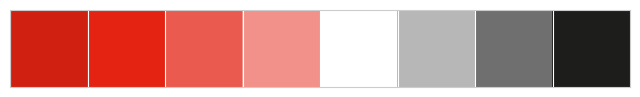

In [4]:
sns.palplot(sns.color_palette())

In [5]:
cmap_name = 'custom_palette'
cm = (plt
      .cm
      .colors
      .LinearSegmentedColormap
      .from_list(cmap_name, 
                 color_palette, 
                 N=len(color_palette)
                )
     )

<a id='section2'></a>
# 2. Helper Functions

In [6]:
def get_var(df, var_name):
    globals()[var_name] = df
    return df

In [7]:
def cat_value_count(df: pd.DataFrame, 
                    col: str,  
                    reindex: list = None) -> pd.DataFrame:
    
    return (pd
            .DataFrame((df[col].value_counts(normalize=i) for i in [False, True]), index=['abs_count', 'norm_count'])
            .T
            .reindex(reindex)
            .assign(cumsum=lambda df_: df_.norm_count.cumsum(),
                    mean_target=df.groupby(col)["churn_label"].mean())
            .pipe(lambda df_: print(f'This categorical predictor has {len(df_)} unique values\n\n', df_))
           )

In [8]:
def outlier_thresholds(df: pd.DataFrame, 
                       col: str, 
                       q1: float = 0.05, 
                       q3: float = 0.95):
    """
    1.5 as multiplier is a rule of thumb. Generally, the higher the multiplier,
    the outlier threshold is set farther from the third quartile, allowing fewer data points to be classified as outliers
    """

    return (df[col].quantile(q1) - 1.5 * (df[col].quantile(q3) - df[col].quantile(q1)),
            df[col].quantile(q3) + 1.5 * (df[col].quantile(q3) - df[col].quantile(q1)))

def loc_potential_outliers(df: pd.DataFrame,
                           col: str):
    """
    Locate potential outliers and print the result in DataFrame
    """
    
    low, high = outlier_thresholds(df, col)
    res = df.loc[(df[col] < low) | (df[col] > high)]
    print(f'Detected total of {len(res)} potential outliers based on 1.5xIQR with min of {res[col].min()} and max of {res[col].max()}')
    return res

def any_potential_outlier(df: pd.DataFrame, 
                          col: str) -> int:
    """
    Quick check on outlier counts across columns
    """
    
    low, high = outlier_thresholds(df, col)
    outlier_condition = (df[col] > high) | (df[col] < low)
    
    if outlier_condition.any():
        return df.loc[outlier_condition].shape[0]
    else:
        return 0
    
def delete_potential_outlier(df: pd.DataFrame,
                             col: str) -> pd.DataFrame:
    """
    Replace outliers value with np.nan
    """
    
    low, high = outlier_thresholds(df, col)
    df.loc[(df[col]>high) | (df[col]<low),col] = np.nan
    return df

def delete_potential_outlier_list(df: pd.DataFrame,
                                  cols: list) -> pd.DataFrame:
    """
    Put in list all the columns which outliers are to be replace with np.nan
    """
    
    for item in cols:
        df = delete_potential_outlier(df, item)
    return df

In [9]:
def plot_continuous(df: pd.DataFrame, 
                    col: str, 
                    title: str, 
                    symb: str):
    """
    Plot a Boxplot and Histogram to inspect continuous values distribution.
    """
    
    with sns.plotting_context(rc={"font":"Roboto", "palette":color_palette, "grid.linewidth":1.0, "font.size":12.0}):
        fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5), gridspec_kw={"height_ratios": (.2, .8)})

        ax[0].set_title(title,fontsize=18)
        (df
         [[col]]
         .boxplot(ax=ax[0], vert=False))

        ax[0].set(yticks=[])
        
        # Remove the spines for the first axis
        for spine in ['top', 'bottom', 'left', 'right']:
            ax[0].spines[spine].set_visible(False)

        (so
         .Plot(df,
               x=col)
         .add(so.Bars(color=color_palette[0]), so.Hist(bins=50))
         .label(x=col,
                y='Frequency',
                color=str.capitalize,)
         .on(ax[1])
         .plot()
        )
        
        # Remove the spines for the second axis
        for spine in ['top', 'bottom', 'left', 'right']:
            ax[1].spines[spine].set_visible(False)

        plt.axvline(df[col].mean(), color=color_palette[2], linestyle='--', linewidth=2.2, label='mean=' + str(np.round(df[col].astype('float64').mean(),1)) + symb)
        plt.axvline(df[col].median(), color=color_palette[3], linestyle='--', linewidth=2.2, label='median='+ str(np.round(df[col].median(),1)) + symb)
        plt.axvline(df[col].mode()[0], color=color_palette[4], linestyle='--', linewidth=2.2, label='mode='+ str(np.round(df[col].mode()[0],1)) + symb)
        plt.axvline(df[col].min(), color=color_palette[5], linestyle='--', linewidth=2.2, label='min='+ str(np.round(df[col].min(),1)) + symb)
        plt.axvline(df[col].max(), color=color_palette[6], linestyle='--', linewidth=2.2, label='max='+ str(np.round(df[col].max(),1)) + symb)
        plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fontsize=10, fancybox=True, shadow=True, frameon=True)
        
        plt.tight_layout()
        plt.show()
        
        plt.close('all')

In [10]:
def plot_qq(df: pd.DataFrame,
            column: str):
    """
    Quantile plot to observe normality
    """
    
    plt.figure()
    stats.probplot(df[column], dist="norm", plot=plt)
    plt.title(f"QQ Plot of {column}")
    plt.gca().get_lines()[0].set_markerfacecolor('#1E1A0F')
    plt.gca().get_lines()[0].set_markeredgecolor('#1E1A0F')
    plt.gca().get_lines()[1].set_color('#575735')
    plt.show()

In [11]:
def test_normality(df: pd.DataFrame, 
                   column: str, 
                   sample_size:int=5000, 
                   random_state:int=1):
    """
    Test the normality of a column in a dataframe using Shapiro-Wilk and D'Agostino and Pearson's tests.
    """

    sample_data = df[column].sample(n=sample_size, random_state=random_state)

    # Shapiro-Wilk Test
    shapiro_test_stat, shapiro_p_value = stats.shapiro(sample_data)
    print(f'Shapiro-Wilk Test (on sample data):\n Test Statistic: {shapiro_test_stat}\n p-value: {shapiro_p_value}')

    # D'Agostino and Pearson's Test
    dagostino_test_stat, dagostino_p_value = stats.normaltest(df[column])
    print(f"\nD'Agostino and Pearson's Test:\n Test Statistic: {dagostino_test_stat}\n p-value: {dagostino_p_value}")

    if shapiro_p_value > 0.05 and dagostino_p_value > 0.05:
        print("\nBoth tests failed to reject the null hypothesis, suggesting the data is normally distributed.")
    else:
        print("\nAt least one of the tests rejected the null hypothesis, suggesting the data is not normally distributed.")

In [12]:
def plot_scatter(df: pd.DataFrame,
                 x: str,
                 y: str,):
    return (so
            .Plot(df,
                  x=x, 
                  y=y)
            .add(so.Dots(color=color_palette[7], alpha=0.5))
            .label(x=x,
                   y=y,
                   color=str.capitalize,
                   title=f'Plot of {y} v. {x}')
            .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[7]]), 
                    "axes.facecolor": "w", 
                    "grid.color": "#ffffff"}))

In [13]:
def plot_clf(df: pd.DataFrame,
             x: str,) -> so:
    """
    Plot classifying features distribution according to target no rain / rain 
    """
    
    return (so
            .Plot(df_tweaked_rmout_fe,
                  x=x,)
            .add(so.Area(alpha=.7),
                 so.KDE(),
                 color="rain_1h_cat",)
            .scale(y=so.Continuous())
            .theme({"axes.prop_cycle": matplotlib.cycler(color=color_palette[7]), "axes.facecolor": "w", "grid.color": "#ffffff"})
            .label(title=f'Distribution of {x} for no rain/rain')
           )

In [14]:
def value_counts_proportion(df: pd.DataFrame,
                            col: str) -> so:
    """
    Examining the proportion of discrete value in a feature
    """
    
    return (df
            [col]
            .value_counts(dropna=False, normalize=True)
            .reset_index()
            .assign(**{col: lambda df_: df_[col].fillna('NaN')})
           )

In [15]:
def value_counts_plot(df: pd.DataFrame,
                      col: str) -> so:
    """
    Plotting out the proportion of discrete value in a feature
    """
    
    fig, ax = plt.subplots(figsize=(8,4))
    ax.xaxis.set_tick_params(rotation=45)

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)

    return (so
            .Plot(df[col], df["proportion"])
            .add(so.Bar(color=color_palette[2], alpha=1))
            .label(x='Unique Values',
                   y='Percentage',
                   color=str.capitalize,
                   title=f'Value Counts Normalised in {col} feature',
                  )
            .theme({"axes.facecolor": "w", "grid.color": "#ffffff"})
            .on(ax)
            .plot()
           );

In [16]:
def plot_categorical(df: pd.DataFrame, 
                     col: str, 
                     new_index: list = None) -> so:

    df_to_plot = df[col].value_counts(normalize=True).to_frame().reset_index()

    if new_index is not None:
        df_to_plot = df_to_plot.set_index('index').reindex(new_index).reset_index()

    return (so
            .Plot(df_to_plot, x=col, y='proportion')
            .add(so.Bar(color=color_palette[2], alpha=1.0, edgewidth=0))
            .theme({"axes.facecolor": "w", "grid.color": "#ffffff"})
            .label(x='',
                   y=col,
                   color=str.capitalize,
                   title=f'Normalised Count of {col}')
            .show()
           )

def plot_features_label(df: pd.DataFrame,
                        col: str,
                        new_index: list = None) -> so:
    
    df_to_plot = (df
                   .groupby([col])
                   .churn_label #y
                   .value_counts(normalize=False)
                   .unstack(level=1)
                 )
    
    if new_index is not None:
        df_to_plot = df_to_plot.reindex(new_index)
    
    return (so
            .Plot((df_to_plot
                   .reset_index()
                   .rename(columns={0: '0', 1: '1'})
                   .melt(id_vars=col, var_name='decision', value_name='proportion')
                  ),
                  x='proportion',
                  y=col,
                  color='decision'
                 )
            .add(so.Bar(edgewidth=0),
                 so.Dodge())
            .theme({"axes.facecolor": "w", "grid.color": "#ffffff"})
            .label(x='',
                   y=col,
                   color=str.capitalize,
                   title=f'{col} v. Churn Outcome')
            .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[0], color_palette[3]])})
            .plot()
           )

def plot_label_features(df: pd.DataFrame,
                        col: str) -> so:
    
    df_to_plot = (df
                   .groupby([col])
                   .churn_label #y
                   .value_counts(normalize=True)
                   .unstack(level=0)
                 )
        
    return (so
            .Plot((df_to_plot
                   .reset_index()
                   .melt(id_vars='churn_label', var_name=col, value_name='proportion')
                  ),
                  x='proportion',
                  y='churn_label',
                  color=col
                 )
            .add(so.Bar(edgewidth=0),
                 so.Dodge(),
                 orient='y')
            .label(x='',
                   y='churn_label',
                   color=str.capitalize,
                   title=f'{col} v. Churn Outcome')
            .scale(y=so.Continuous().tick(at=[0, 1]))
            .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[0], color_palette[3], color_palette[2], color_palette[5]]), "axes.facecolor": "w", "grid.color": "#ffffff"})
            .plot()
           )

<a id='section3'></a>
# 3. Dataset Info

   #### Source:
   https://www.kaggle.com/datasets/0912a4f3cb904b0704b7826a288fd8d95cfa677d2a5589336904d05da33d2638

   #### Data Challenge DSW 2023 - Student & Junior Pro
   Data Challenge DSW 2023 Students & Junior Professional Category

   #### Problem Statement
   A telecommunication company wants to analyze its customer’s behavior. Given the following dataset, build a solution that aims to provide meaningful insights to the telecommunication company. The solution can be in the form of an AI model, dashboard, or analysis report. If participants plan to build an AI model, participants are free to decide features, labels, and metrics when building the model. You are expected to propose an innovative solution from the dataset.
    
   #### Original Source:
   https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset 


   #### Train data:
| No. | Features | Description |
| :-------- | :-------- | :-------- |
| 1. | Customer ID | A unique customer identifier |
| 2. | Tenure Months | How long the customer has been with the company by the end of the quarter specified above |
| 3. | Location | Customer's residence - City |
| 4. | Device Class | Device classification |
| 5. | Games Product | Whether the customer uses the internet service for games product |
| 6. | Music Product | Whether the customer uses the internet service for music product |
| 7. | Education Product | Whether the customer uses the internet service for education product |
| 8. | Call Center | Whether the customer uses the call center service |
| 9. | Video Product | Whether the customer uses video product service |
| 10. | Use MyApp | Whether the customer uses MyApp service |
| 11. | Payment Method | The method used for paying the bill |
| 12. | Monthly Purchase | Total customer’s monthly spent for all services with the unit of thousands of IDR |
| 13. | Churn Label | Whether the customer left the company in this quarter |
| 14. | Longitude | Customer’s residence - Longitude |
| 15. | Latitude | Customer’s residence - Latitude |
| 16. | CLTV | Customer Lifetime Value with the unit of thousands of IDR - Calculated using company's formulas |

<a id='section4'></a>
# 4. Exploratory Data Analysis

<a id='section4_1'></a>
## 4.1. Structure Investigation

In [17]:
(df
 .head()
)

Customer ID  Tenure Months Location Device Class Games Product  \
0            0              2  Jakarta      Mid End           Yes   
1            1              2  Jakarta     High End            No   
2            2              8  Jakarta     High End            No   
3            3             28  Jakarta     High End            No   
4            4             49  Jakarta     High End            No   

  Music Product Education Product Call Center Video Product Use MyApp  \
0           Yes                No          No            No        No   
1            No                No          No            No        No   
2            No               Yes          No           Yes       Yes   
3            No               Yes         Yes           Yes       Yes   
4           Yes               Yes          No           Yes       Yes   

   Payment Method  Monthly Purchase (Thou. IDR)  churn_label   Longitude  \
0  Digital Wallet                        70.005            1  106.816666   
1           Pulsa                        91.910            1  106.816666   
2           Pulsa                       129.545            1  106.816666   
3           Pulsa                       136.240            1  106.816666   
4           Debit                       134.810            1  106.816666   

   Latitude  CLTV (Predicted Thou. IDR)  
0      -6.2                      4210.7  
1      -6.2                      3511.3  
2      -6.2                      6983.6  
3      -6.2                      6503.9  
4      -6.2                      6942.0

In [18]:
(df
 .shape
)

(7043, 16)

In [19]:
(df
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Customer ID                   7043 non-null   int64  
 1   Tenure Months                 7043 non-null   int64  
 2   Location                      7043 non-null   object 
 3   Device Class                  7043 non-null   object 
 4   Games Product                 7043 non-null   object 
 5   Music Product                 7043 non-null   object 
 6   Education Product             7043 non-null   object 
 7   Call Center                   7043 non-null   object 
 8   Video Product                 7043 non-null   object 
 9   Use MyApp                     7043 non-null   object 
 10  Payment Method                7043 non-null   object 
 11  Monthly Purchase (Thou. IDR)  7043 non-null   float64
 12  churn_label                   7043 non-null   int64  
 13  Lon

In [20]:
(df
 .describe()
)

Customer ID  Tenure Months  Monthly Purchase (Thou. IDR)  churn_label  \
count  7043.000000    7043.000000                   7043.000000  7043.000000   
mean   3521.000000      32.371149                     84.190200     0.265370   
std    2033.283305      24.559481                     39.117061     0.441561   
min       0.000000       0.000000                     23.725000     0.000000   
25%    1760.500000       9.000000                     46.150000     0.000000   
50%    3521.000000      29.000000                     91.455000     0.000000   
75%    5281.500000      55.000000                    116.805000     1.000000   
max    7042.000000      72.000000                    154.375000     1.000000   

         Longitude     Latitude  CLTV (Predicted Thou. IDR)  
count  7043.000000  7043.000000                 7043.000000  
mean    107.043246    -6.404184                 5720.384481  
std       0.358316     0.322898                 1537.974298  
min     106.816666    -6.914744                 2603.900000  
25%     106.816666    -6.914744                 4509.700000  
50%     106.816666    -6.200000                 5885.100000  
75%     107.609810    -6.200000                 6994.650000  
max     107.609810    -6.200000                 8450.000000

In [21]:
(pd
 .value_counts(df.dtypes)
)

/var/folders/zx/x3_2llcj0tqd7f6y6p1wdbhr0000gn/T/ipykernel_84038/3413911148.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  .value_counts(df.dtypes)


object     9
float64    4
int64      3
Name: count, dtype: int64

<a id='section4_1_1'></a>
#### 4.1.1. Structure of non-numerical features

In [22]:
# Displaying sample data from object datatype
(df
 .loc[:, df.columns!='Churn Label']
 .select_dtypes(exclude="number")
 .head()
)

Location Device Class Games Product Music Product Education Product  \
0  Jakarta      Mid End           Yes           Yes                No   
1  Jakarta     High End            No            No                No   
2  Jakarta     High End            No            No               Yes   
3  Jakarta     High End            No            No               Yes   
4  Jakarta     High End            No           Yes               Yes   

  Call Center Video Product Use MyApp  Payment Method  
0          No            No        No  Digital Wallet  
1          No            No        No           Pulsa  
2          No           Yes       Yes           Pulsa  
3         Yes           Yes       Yes           Pulsa  
4          No           Yes       Yes           Debit

In [23]:
# Describing columns from object datatype
(df
 .loc[:, df.columns!='Churn label']
 .describe(exclude="number")
)

Location Device Class Games Product Music Product Education Product  \
count      7043         7043          7043          7043              7043   
unique        2            3             3             3                 3   
top     Jakarta     High End            No            No                No   
freq       5031         3096          3498          3088              3095   

       Call Center Video Product Use MyApp Payment Method  
count         7043          7043      7043           7043  
unique           2             3         3              4  
top             No            No        No          Pulsa  
freq          4999          2810      2785           2365

In [24]:
# Understanding unique values from object columns and sort in ascending order
unique_values = (df
                 .loc[:, df.columns!='Churn Label']
                 .select_dtypes(include="O")
                 .nunique()
                 .sort_values())
unique_values

Location             2
Call Center          2
Device Class         3
Games Product        3
Music Product        3
Education Product    3
Video Product        3
Use MyApp            3
Payment Method       4
dtype: int64

**Note:**
1. Low cardinality categorical features

<a id='section4_1_2'></a>
#### 4.1.2. Structure of numerical features

In [25]:
# Understanding unique values from number columns and sort in ascending order
unique_values = (df
                 .loc[:, df.columns!='Churn Label']
                 .select_dtypes(include="number")
                 .nunique()
                 .sort_values())
unique_values

churn_label                        2
Longitude                          2
Latitude                           2
Tenure Months                     73
Monthly Purchase (Thou. IDR)    1585
CLTV (Predicted Thou. IDR)      3438
Customer ID                     7043
dtype: int64

<a id='section4_2'></a>
## 4.2. Quality Investigation

<a id='section4_2_1'></a>
#### 4.2.1. Duplicated Records

In [26]:
n_duplicates = (df
                .duplicated()
                .sum())
print(f"Detected {n_duplicates} duplicates in your dataset.")

Detected 0 duplicates in your dataset.


<a id='section4_2_2'></a>
#### 4.2.2. Missing Values

In [27]:
(df
 .isna()
 .sum()
)

Customer ID                     0
Tenure Months                   0
Location                        0
Device Class                    0
Games Product                   0
Music Product                   0
Education Product               0
Call Center                     0
Video Product                   0
Use MyApp                       0
Payment Method                  0
Monthly Purchase (Thou. IDR)    0
churn_label                     0
Longitude                       0
Latitude                        0
CLTV (Predicted Thou. IDR)      0
dtype: int64

<a id='section4_3'></a>
## 4.3. Content Investigation

<a id='section4_3_1'></a>
#### 4.3.1. Identifying noise in Variables and Transforming Dataset

In [28]:
df.head()

Customer ID  Tenure Months Location Device Class Games Product  \
0            0              2  Jakarta      Mid End           Yes   
1            1              2  Jakarta     High End            No   
2            2              8  Jakarta     High End            No   
3            3             28  Jakarta     High End            No   
4            4             49  Jakarta     High End            No   

  Music Product Education Product Call Center Video Product Use MyApp  \
0           Yes                No          No            No        No   
1            No                No          No            No        No   
2            No               Yes          No           Yes       Yes   
3            No               Yes         Yes           Yes       Yes   
4           Yes               Yes          No           Yes       Yes   

   Payment Method  Monthly Purchase (Thou. IDR)  churn_label   Longitude  \
0  Digital Wallet                        70.005            1  106.816666   
1           Pulsa                        91.910            1  106.816666   
2           Pulsa                       129.545            1  106.816666   
3           Pulsa                       136.240            1  106.816666   
4           Debit                       134.810            1  106.816666   

   Latitude  CLTV (Predicted Thou. IDR)  
0      -6.2                      4210.7  
1      -6.2                      3511.3  
2      -6.2                      6983.6  
3      -6.2                      6503.9  
4      -6.2                      6942.0

In [29]:
cat_value_count(df, "Location")

This categorical predictor has 2 unique values

           abs_count  norm_count    cumsum  mean_target
Location                                              
Jakarta      5031.0    0.714326  0.714326     0.262970
Bandung      2012.0    0.285674  1.000000     0.271372


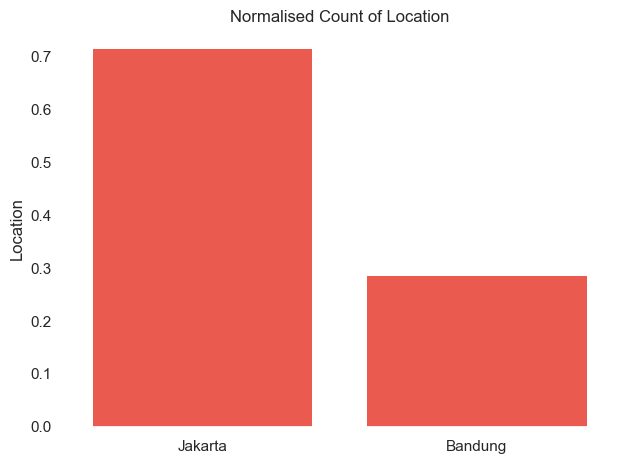

In [30]:
plot_categorical(df, "Location")

In [31]:
cat_value_count(df, "Device Class")

This categorical predictor has 3 unique values

               abs_count  norm_count    cumsum  mean_target
Device Class                                              
High End         3096.0    0.439585  0.439585     0.418928
Mid End          2421.0    0.343746  0.783331     0.189591
Low End          1526.0    0.216669  1.000000     0.074050


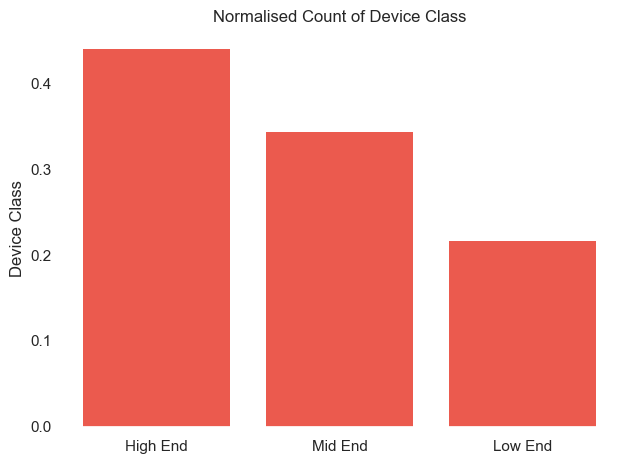

In [32]:
plot_categorical(df, "Device Class")

In [33]:
cat_value_count(df, "Games Product")

This categorical predictor has 3 unique values

                      abs_count  norm_count    cumsum  mean_target
Games Product                                                    
No                      3498.0    0.496663  0.496663     0.417667
Yes                     2019.0    0.286668  0.783331     0.146112
No internet service     1526.0    0.216669  1.000000     0.074050


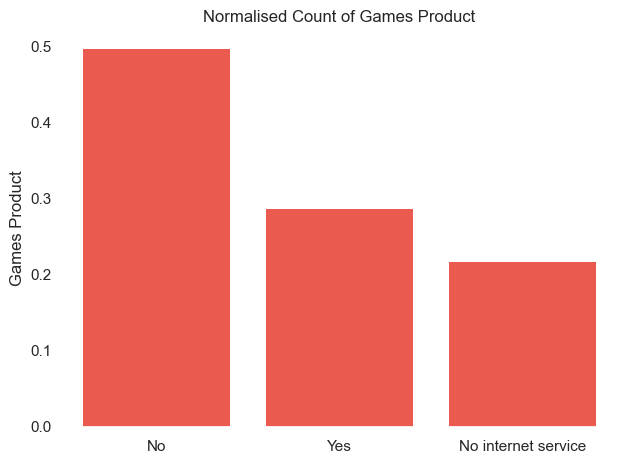

In [34]:
plot_categorical(df, "Games Product")

In [35]:
cat_value_count(df, "Music Product")

This categorical predictor has 3 unique values

                      abs_count  norm_count    cumsum  mean_target
Music Product                                                    
No                      3088.0    0.438450  0.438450     0.399288
Yes                     2429.0    0.344881  0.783331     0.215315
No internet service     1526.0    0.216669  1.000000     0.074050


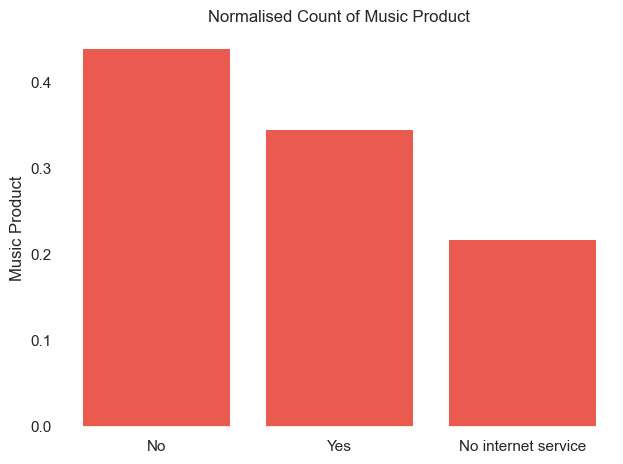

In [36]:
plot_categorical(df, "Music Product")

In [37]:
cat_value_count(df, "Education Product")

This categorical predictor has 3 unique values

                      abs_count  norm_count    cumsum  mean_target
Education Product                                                
No                      3095.0    0.439443  0.439443     0.391276
Yes                     2422.0    0.343888  0.783331     0.225021
No internet service     1526.0    0.216669  1.000000     0.074050


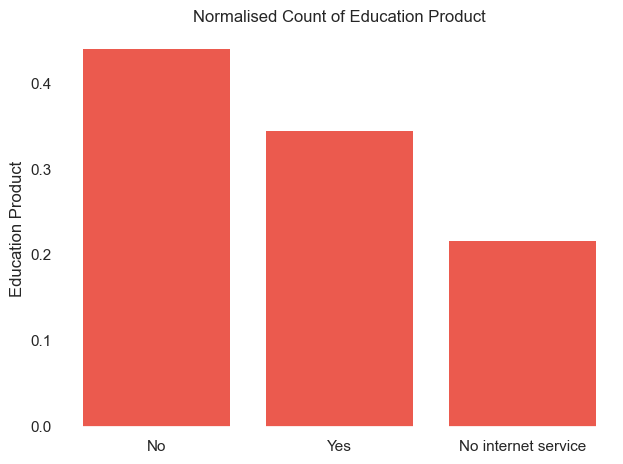

In [38]:
plot_categorical(df, "Education Product")

In [39]:
cat_value_count(df, "Video Product")

This categorical predictor has 3 unique values

                      abs_count  norm_count    cumsum  mean_target
Video Product                                                    
No                      2810.0    0.398978  0.398978     0.335231
Yes                     2707.0    0.384353  0.783331     0.300702
No internet service     1526.0    0.216669  1.000000     0.074050


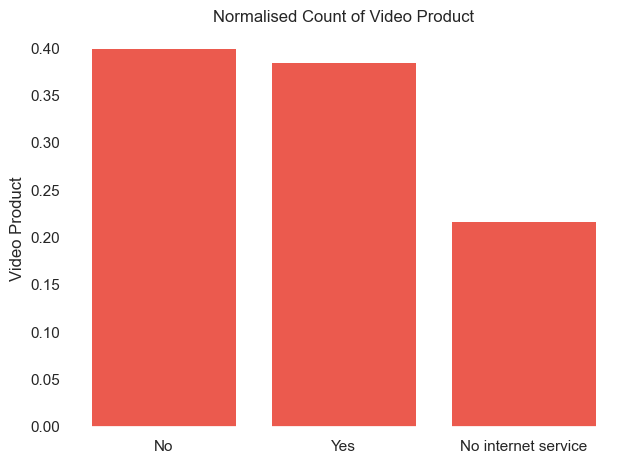

In [40]:
plot_categorical(df, "Video Product")

In [41]:
cat_value_count(df, "Call Center")

This categorical predictor has 2 unique values

              abs_count  norm_count    cumsum  mean_target
Call Center                                              
No              4999.0    0.709783  0.709783     0.311862
Yes             2044.0    0.290217  1.000000     0.151663


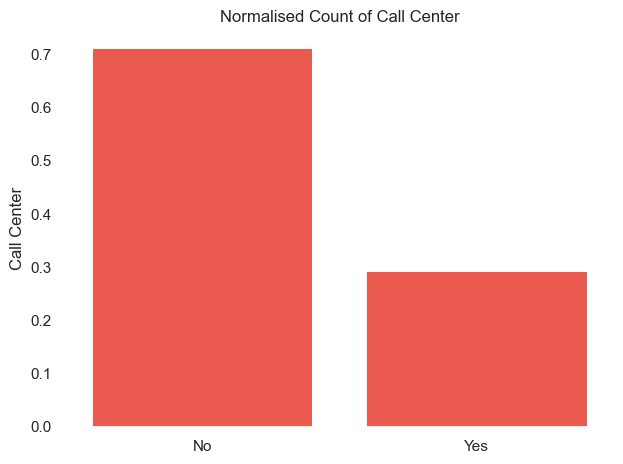

In [42]:
plot_categorical(df, "Call Center")

In [43]:
cat_value_count(df, "Use MyApp")

This categorical predictor has 3 unique values

                      abs_count  norm_count    cumsum  mean_target
Use MyApp                                                        
No                      2785.0    0.395428  0.395428     0.336804
Yes                     2732.0    0.387903  0.783331     0.299414
No internet service     1526.0    0.216669  1.000000     0.074050


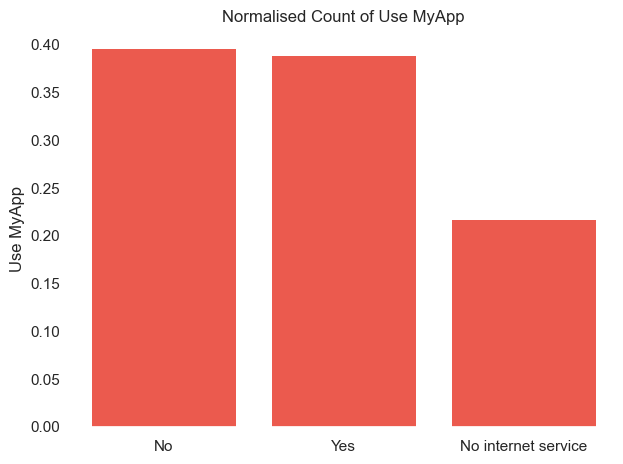

In [44]:
plot_categorical(df, "Use MyApp")

In [45]:
cat_value_count(df, "Payment Method")

This categorical predictor has 4 unique values

                 abs_count  norm_count    cumsum  mean_target
Payment Method                                              
Pulsa              2365.0    0.335794  0.335794     0.452854
Digital Wallet     1612.0    0.228880  0.564674     0.191067
Debit              1544.0    0.219225  0.783899     0.167098
Credit             1522.0    0.216101  1.000000     0.152431


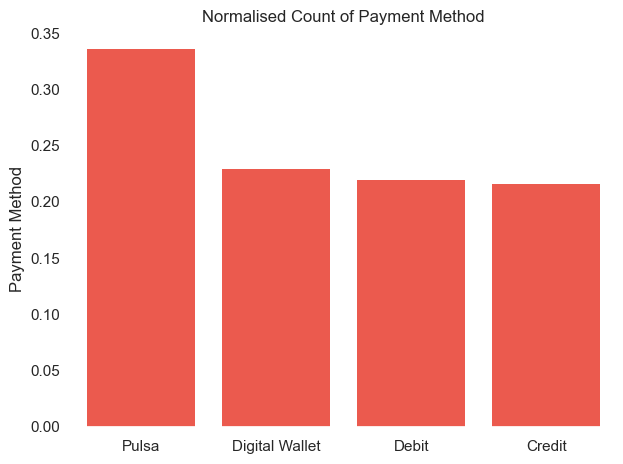

In [46]:
plot_categorical(df, "Payment Method")

In [47]:
# Examining our target variable
cat_value_count(df, "churn_label")

This categorical predictor has 2 unique values

              abs_count  norm_count   cumsum  mean_target
churn_label                                             
0               5174.0     0.73463  0.73463          0.0
1               1869.0     0.26537  1.00000          1.0


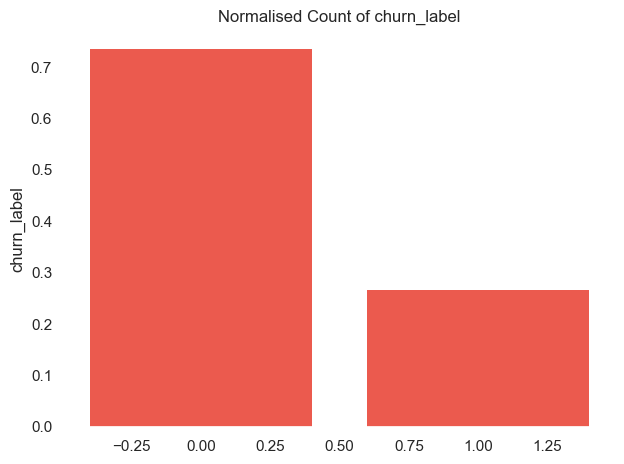

In [48]:
plot_categorical(df, "churn_label")

<a id='section4_3_2'></a>
#### 4.3.2. Feature Distribution

<a id='section4_3_2_1'></a>
##### 4.3.2.1. Univariate Analysis (Continuous features)

The analysis in this secction is meant to detect the presence and position of outliers with respect to the distribution of features.

In [49]:
(df
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Customer ID                   7043 non-null   int64  
 1   Tenure Months                 7043 non-null   int64  
 2   Location                      7043 non-null   object 
 3   Device Class                  7043 non-null   object 
 4   Games Product                 7043 non-null   object 
 5   Music Product                 7043 non-null   object 
 6   Education Product             7043 non-null   object 
 7   Call Center                   7043 non-null   object 
 8   Video Product                 7043 non-null   object 
 9   Use MyApp                     7043 non-null   object 
 10  Payment Method                7043 non-null   object 
 11  Monthly Purchase (Thou. IDR)  7043 non-null   float64
 12  churn_label                   7043 non-null   int64  
 13  Lon

In [50]:
print(f'Based on 1.5xIQR outlier detection formula:\n')
for col in ['Tenure Months', 'Monthly Purchase (Thou. IDR)', 'CLTV (Predicted Thou. IDR)']:
    print(f'Column {col}: Detected total of {any_potential_outlier(df, col)} potential outliers')

Based on 1.5xIQR outlier detection formula:

Column Tenure Months: Detected total of 0 potential outliers
Column Monthly Purchase (Thou. IDR): Detected total of 0 potential outliers
Column CLTV (Predicted Thou. IDR): Detected total of 0 potential outliers


<a id='section4_3_2_2'></a>
##### 4.3.2.2. Normality Check

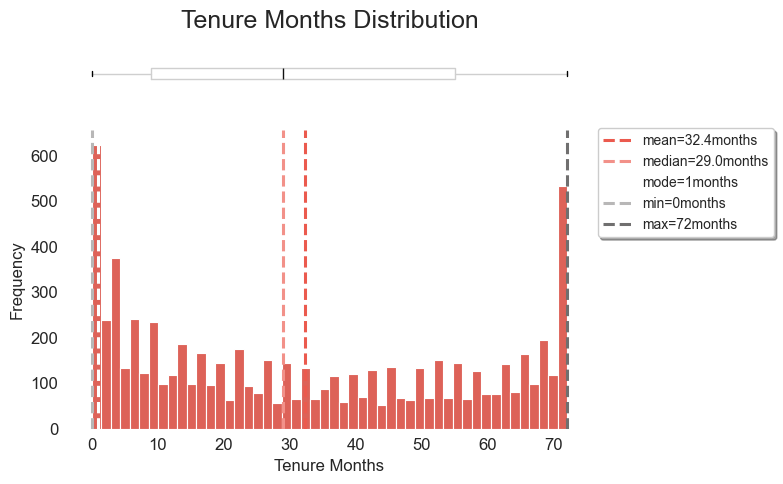

In [51]:
plot_continuous(df, 'Tenure Months', 'Tenure Months Distribution', 'months')

In [52]:
test_normality(df, 'Tenure Months')

Shapiro-Wilk Test (on sample data):
 Test Statistic: 0.9036818932561957
 p-value: 1.3976540304287657e-48

D'Agostino and Pearson's Test:
 Test Statistic: 76258.50517392668
 p-value: 0.0

At least one of the tests rejected the null hypothesis, suggesting the data is not normally distributed.


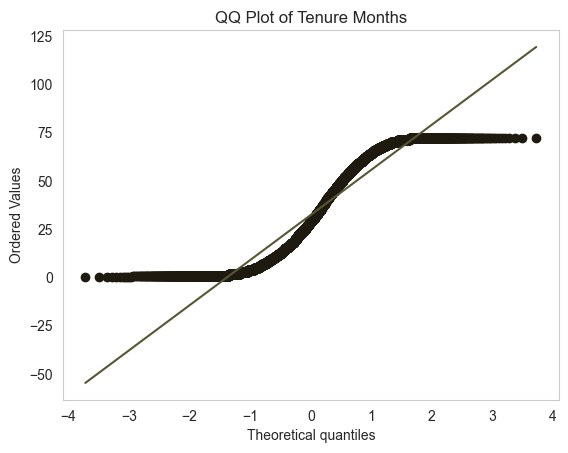

In [53]:
plot_qq(df, "Tenure Months")

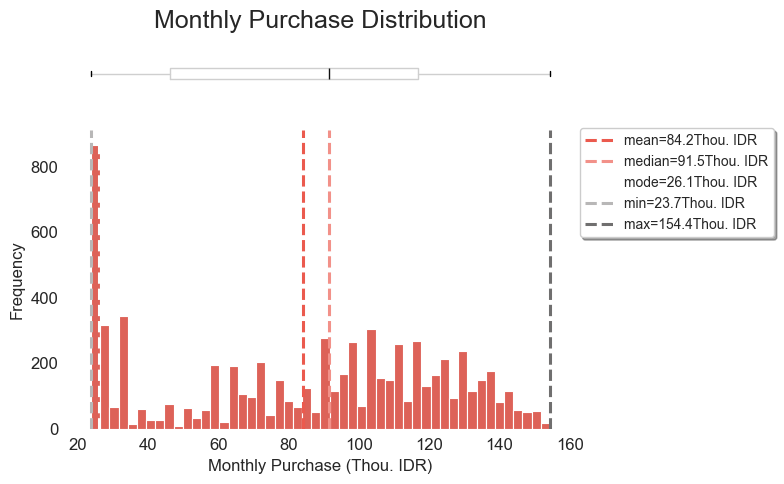

In [54]:
plot_continuous(df, 'Monthly Purchase (Thou. IDR)', 'Monthly Purchase Distribution', 'Thou. IDR')

In [55]:
test_normality(df, 'Monthly Purchase (Thou. IDR)')

Shapiro-Wilk Test (on sample data):
 Test Statistic: 0.9207712107914007
 p-value: 2.255905926817955e-45

D'Agostino and Pearson's Test:
 Test Statistic: 11419.528789007874
 p-value: 0.0

At least one of the tests rejected the null hypothesis, suggesting the data is not normally distributed.


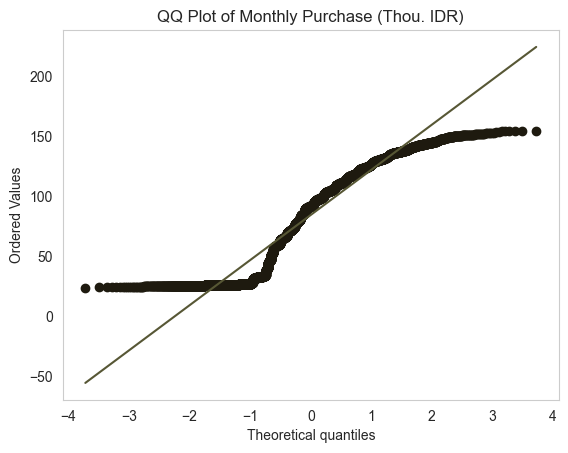

In [56]:
plot_qq(df, "Monthly Purchase (Thou. IDR)")

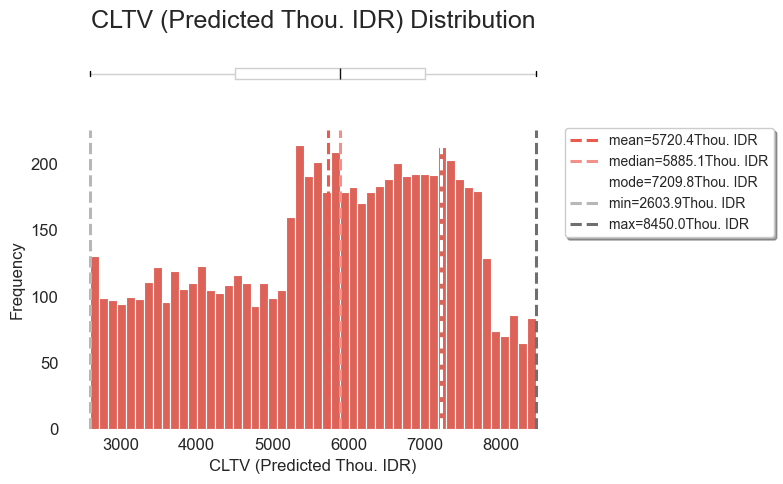

In [57]:
plot_continuous(df, 'CLTV (Predicted Thou. IDR)', 'CLTV (Predicted Thou. IDR) Distribution', 'Thou. IDR')

In [58]:
test_normality(df, 'CLTV (Predicted Thou. IDR)')

Shapiro-Wilk Test (on sample data):
 Test Statistic: 0.9633557847985887
 p-value: 8.121160359148395e-34

D'Agostino and Pearson's Test:
 Test Statistic: 1248.6015263965353
 p-value: 7.406678521560336e-272

At least one of the tests rejected the null hypothesis, suggesting the data is not normally distributed.


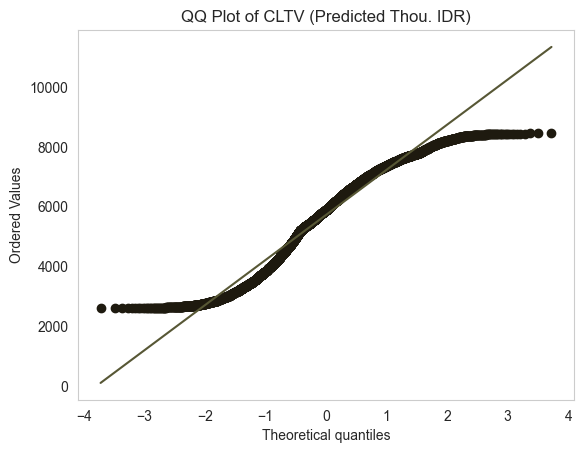

In [59]:
plot_qq(df, "CLTV (Predicted Thou. IDR)")

<a id='section4_3_3'></a>
#### 4.3.3. Bivariate Analysis (Numerical Features v Target)

<a id='section4_3_3_1'></a>
##### 4.3.3.1. Bivariate Analysis (Numerical Features v Target Binary)

In [60]:
(df
 .select_dtypes('number')
 .corr(method='spearman')
 .style
 .background_gradient(cmap=cm, axis=None)
 .set_sticky(axis="index")
 .set_sticky(axis="columns")
)

In [61]:
(df
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Customer ID                   7043 non-null   int64  
 1   Tenure Months                 7043 non-null   int64  
 2   Location                      7043 non-null   object 
 3   Device Class                  7043 non-null   object 
 4   Games Product                 7043 non-null   object 
 5   Music Product                 7043 non-null   object 
 6   Education Product             7043 non-null   object 
 7   Call Center                   7043 non-null   object 
 8   Video Product                 7043 non-null   object 
 9   Use MyApp                     7043 non-null   object 
 10  Payment Method                7043 non-null   object 
 11  Monthly Purchase (Thou. IDR)  7043 non-null   float64
 12  churn_label                   7043 non-null   int64  
 13  Lon

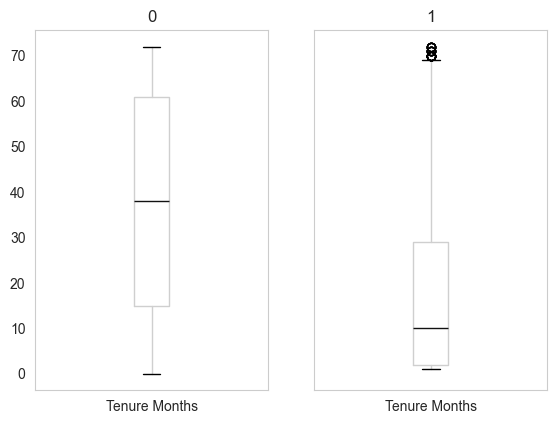

In [62]:
(df
 .groupby('churn_label')
 .boxplot(column=['Tenure Months'])
);

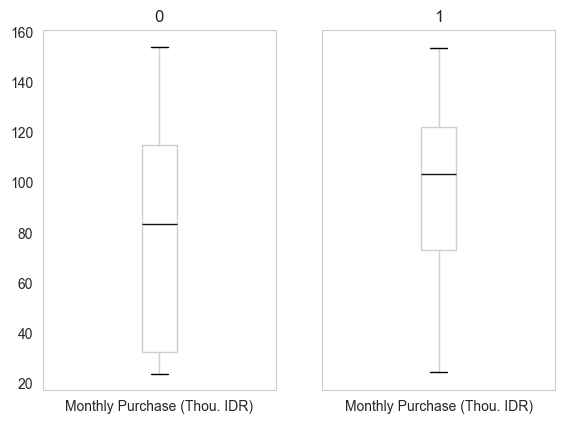

In [63]:
(df
 .groupby('churn_label')
 .boxplot(column=['Monthly Purchase (Thou. IDR)'])
);

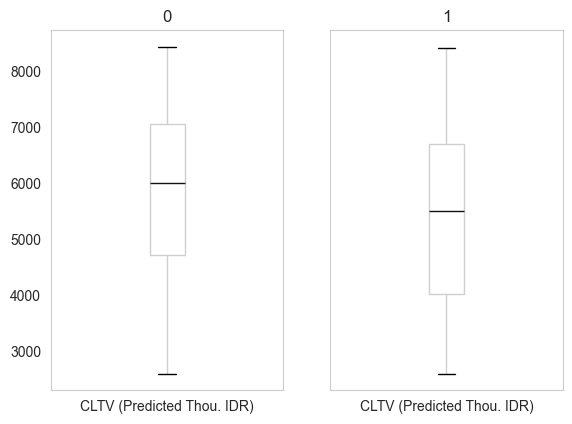

In [64]:
(df
 .groupby('churn_label')
 .boxplot(column=['CLTV (Predicted Thou. IDR)'])
);

<a id='section4_3_3_2'></a>
##### 4.3.3.2. Bivariate Analysis (Categorical Features v Label)

In [65]:
(df
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Customer ID                   7043 non-null   int64  
 1   Tenure Months                 7043 non-null   int64  
 2   Location                      7043 non-null   object 
 3   Device Class                  7043 non-null   object 
 4   Games Product                 7043 non-null   object 
 5   Music Product                 7043 non-null   object 
 6   Education Product             7043 non-null   object 
 7   Call Center                   7043 non-null   object 
 8   Video Product                 7043 non-null   object 
 9   Use MyApp                     7043 non-null   object 
 10  Payment Method                7043 non-null   object 
 11  Monthly Purchase (Thou. IDR)  7043 non-null   float64
 12  churn_label                   7043 non-null   int64  
 13  Lon

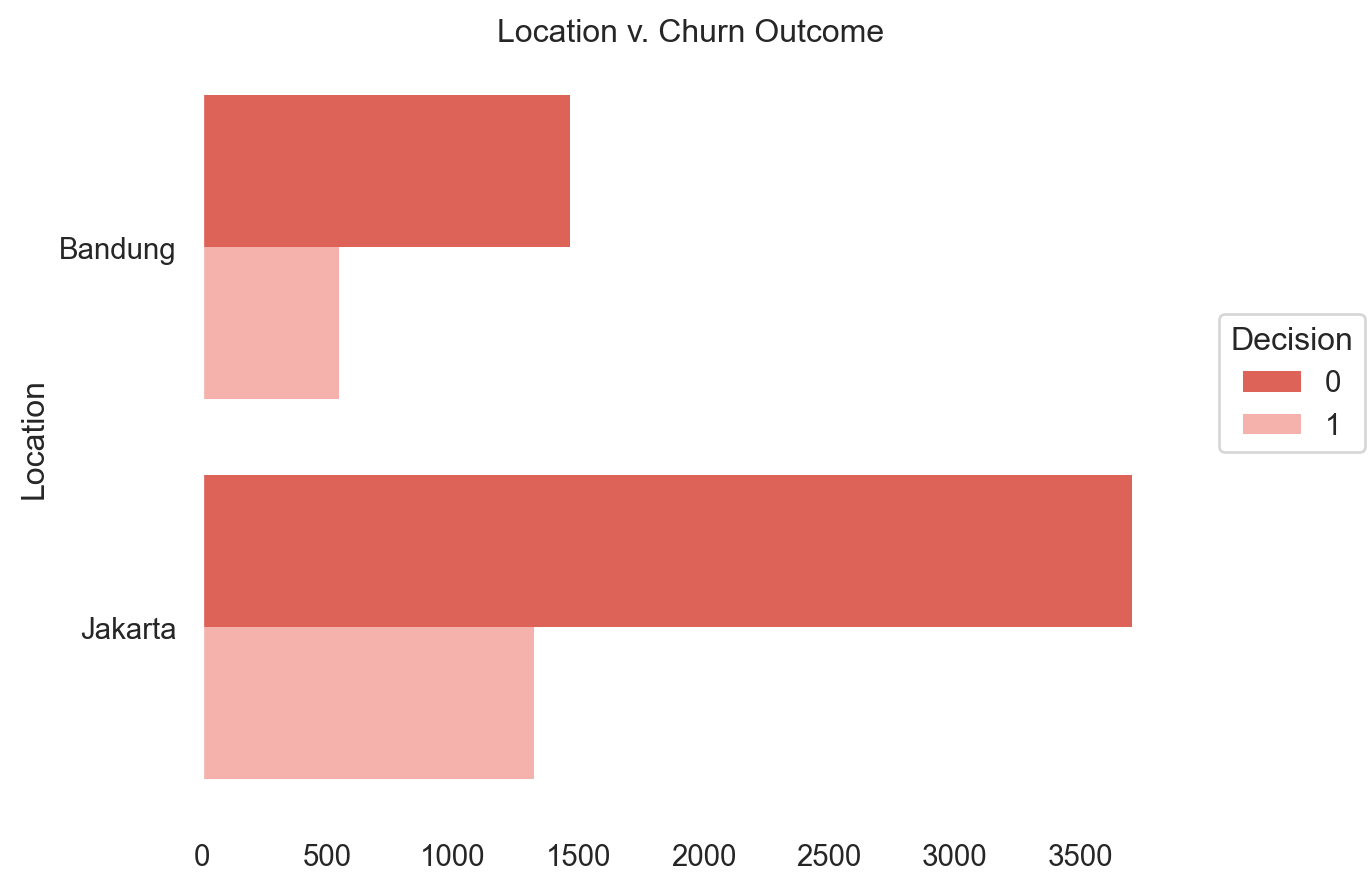

In [66]:
plot_features_label(df, "Location")

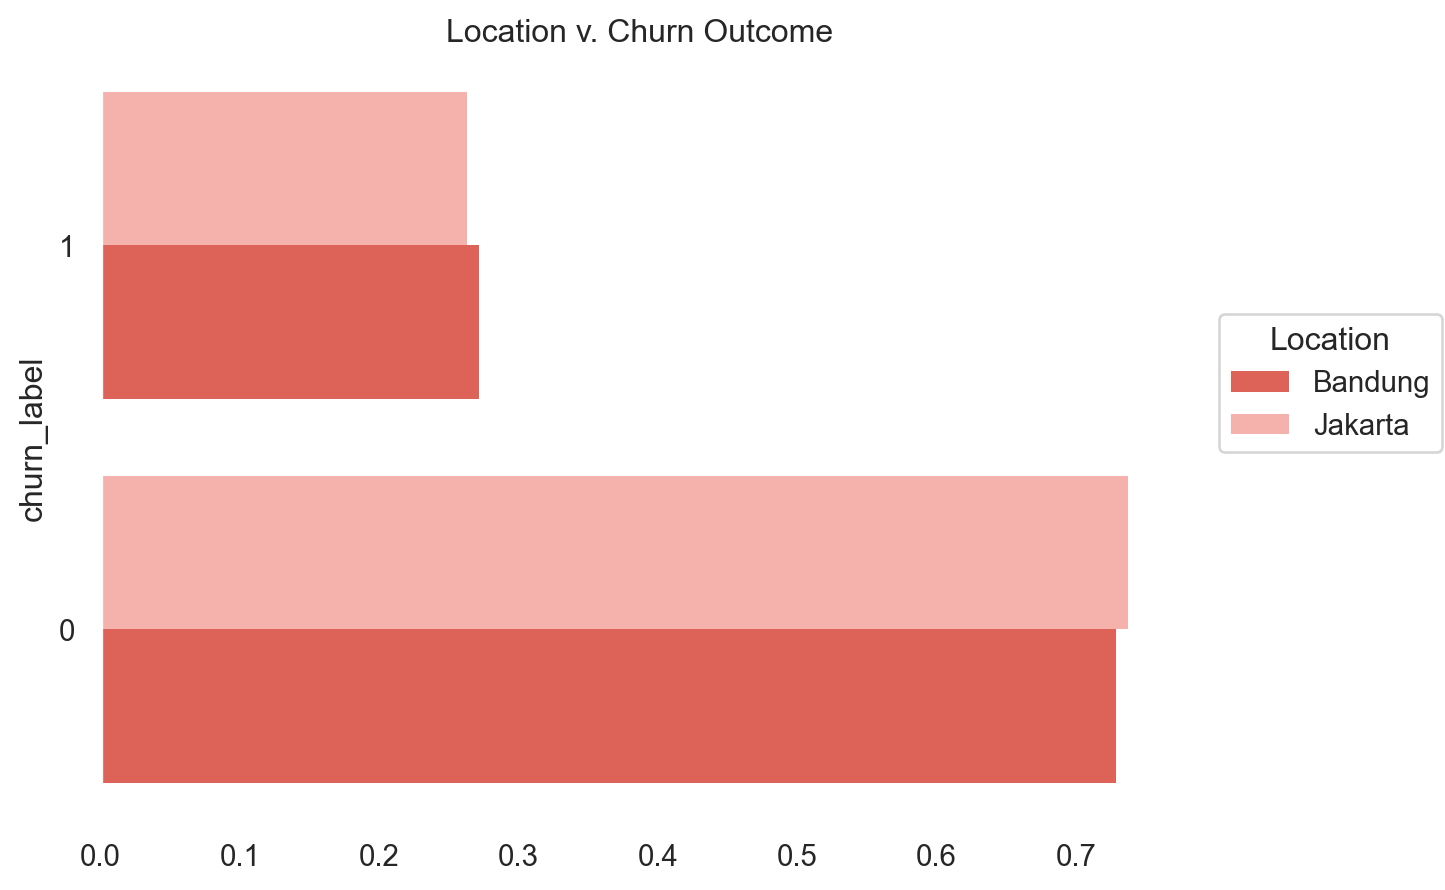

In [67]:
plot_label_features(df, "Location")

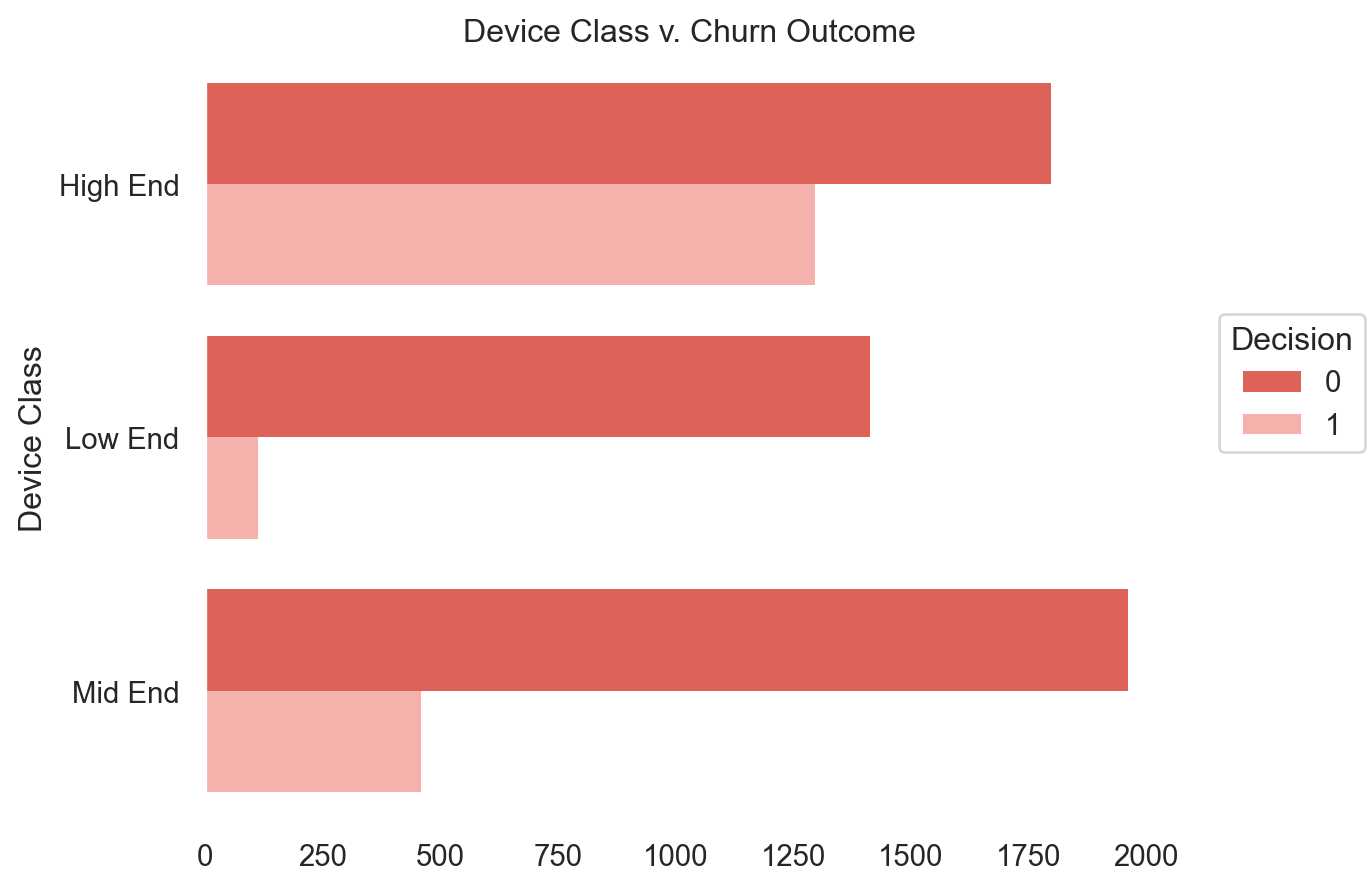

In [68]:
plot_features_label(df, "Device Class")

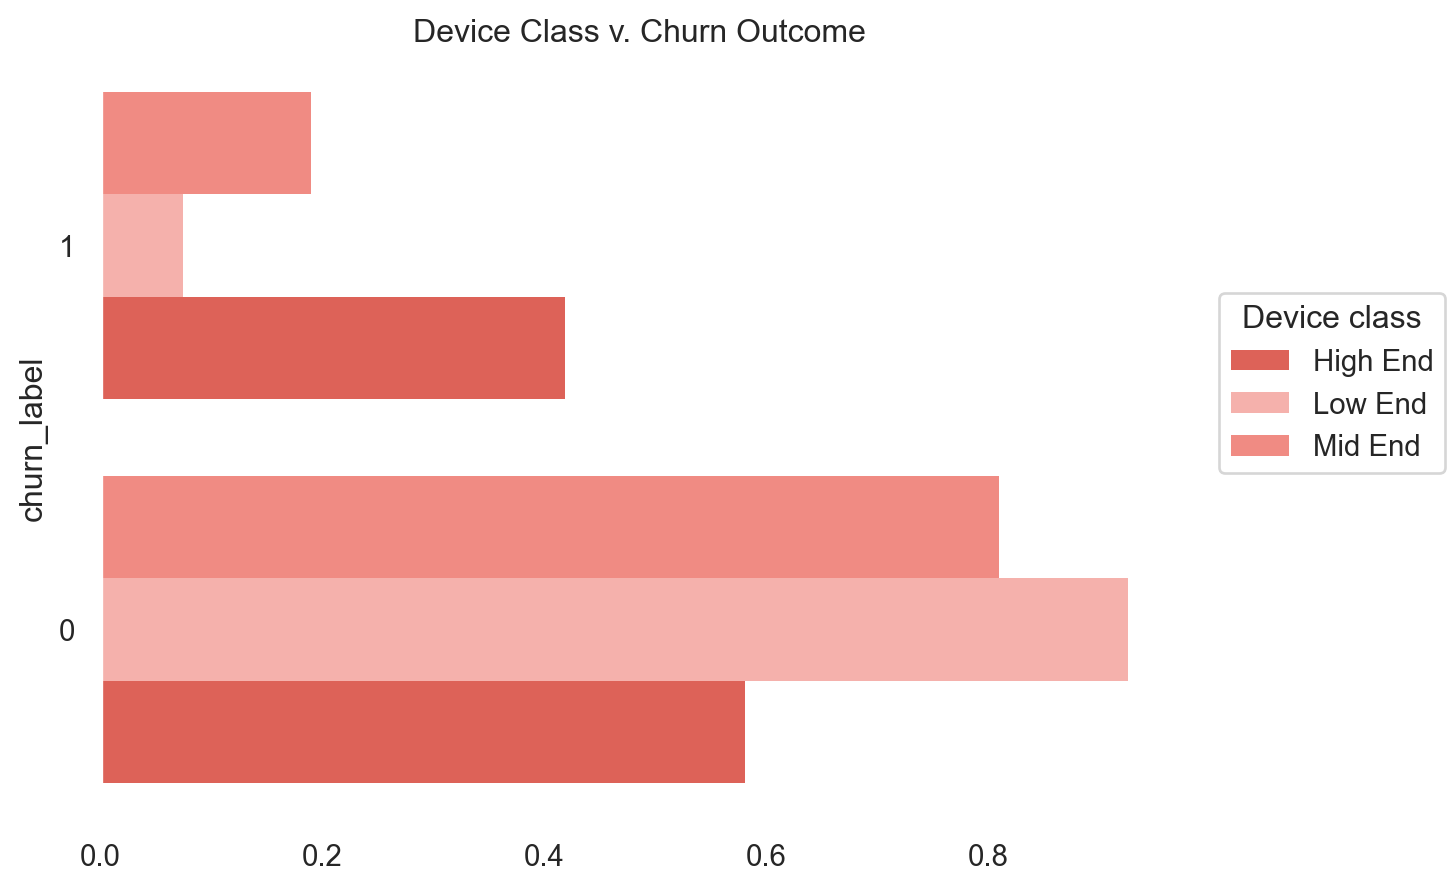

In [69]:
plot_label_features(df, "Device Class")

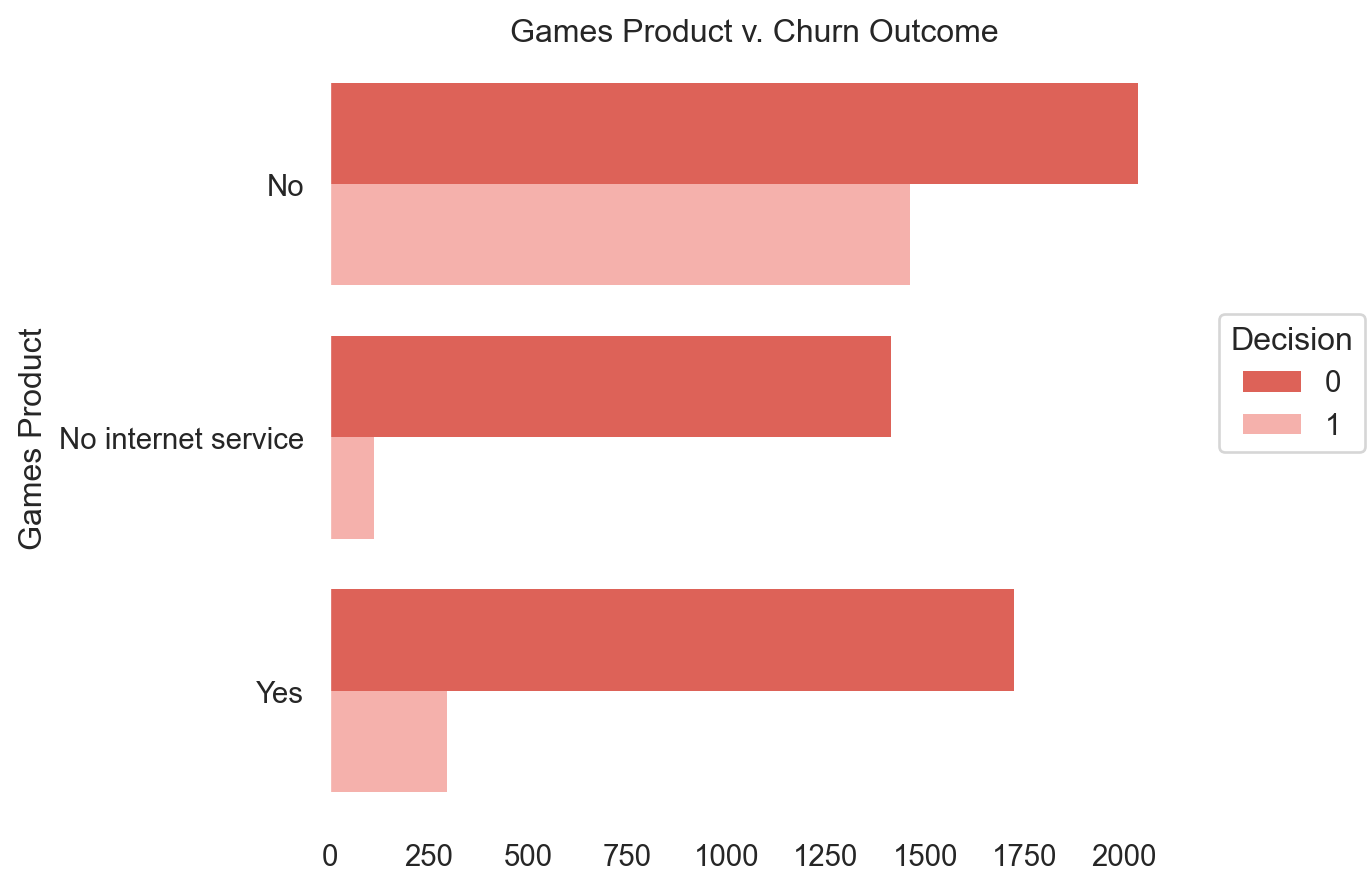

In [70]:
plot_features_label(df, "Games Product")

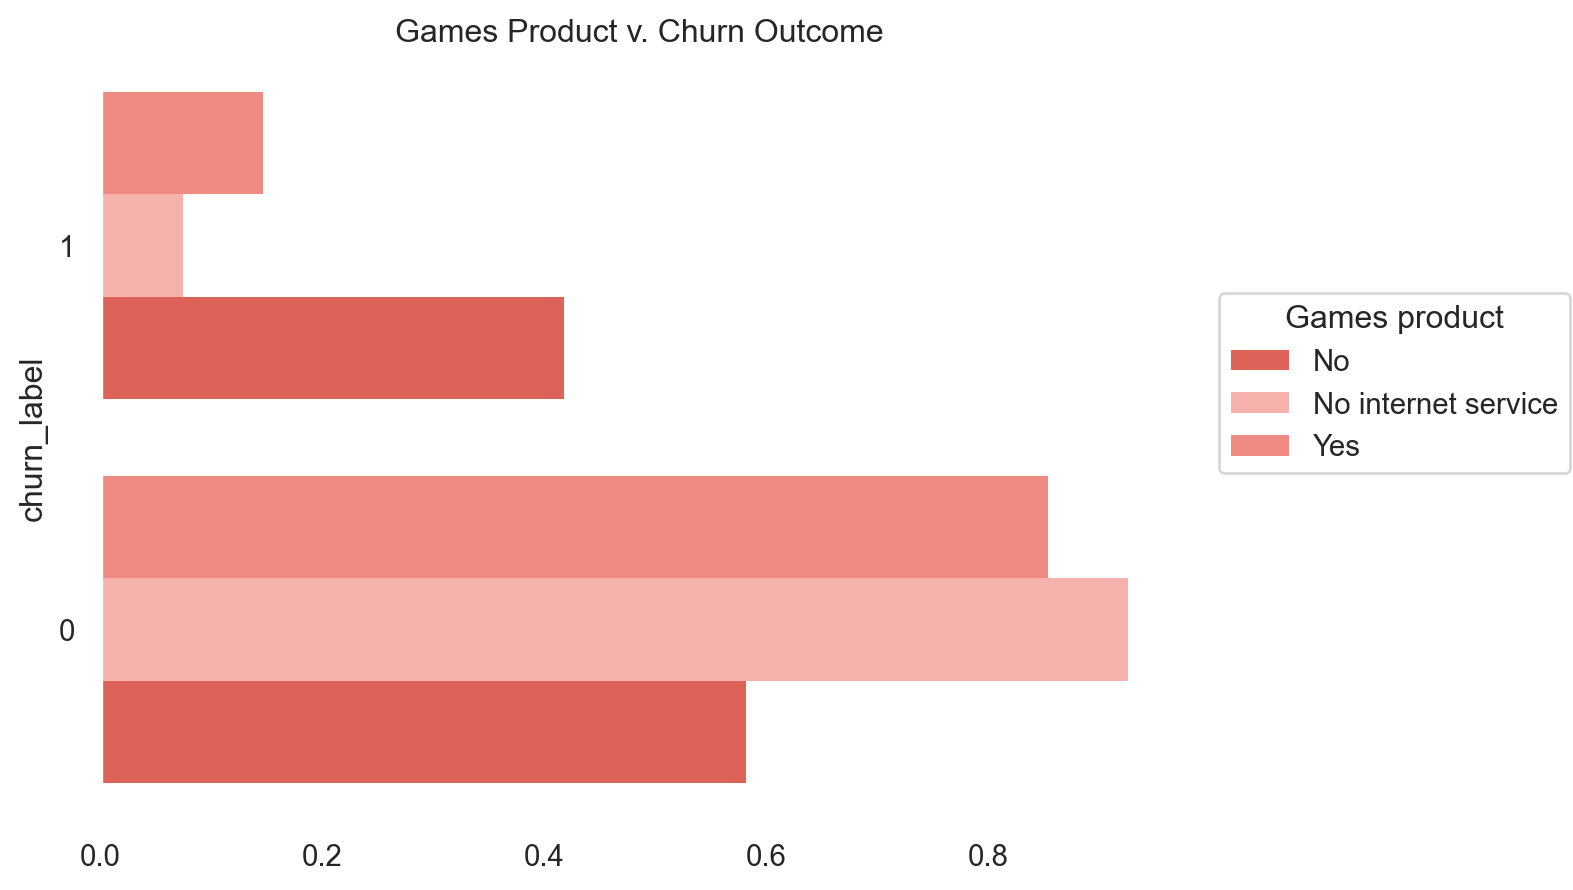

In [71]:
plot_label_features(df, "Games Product")

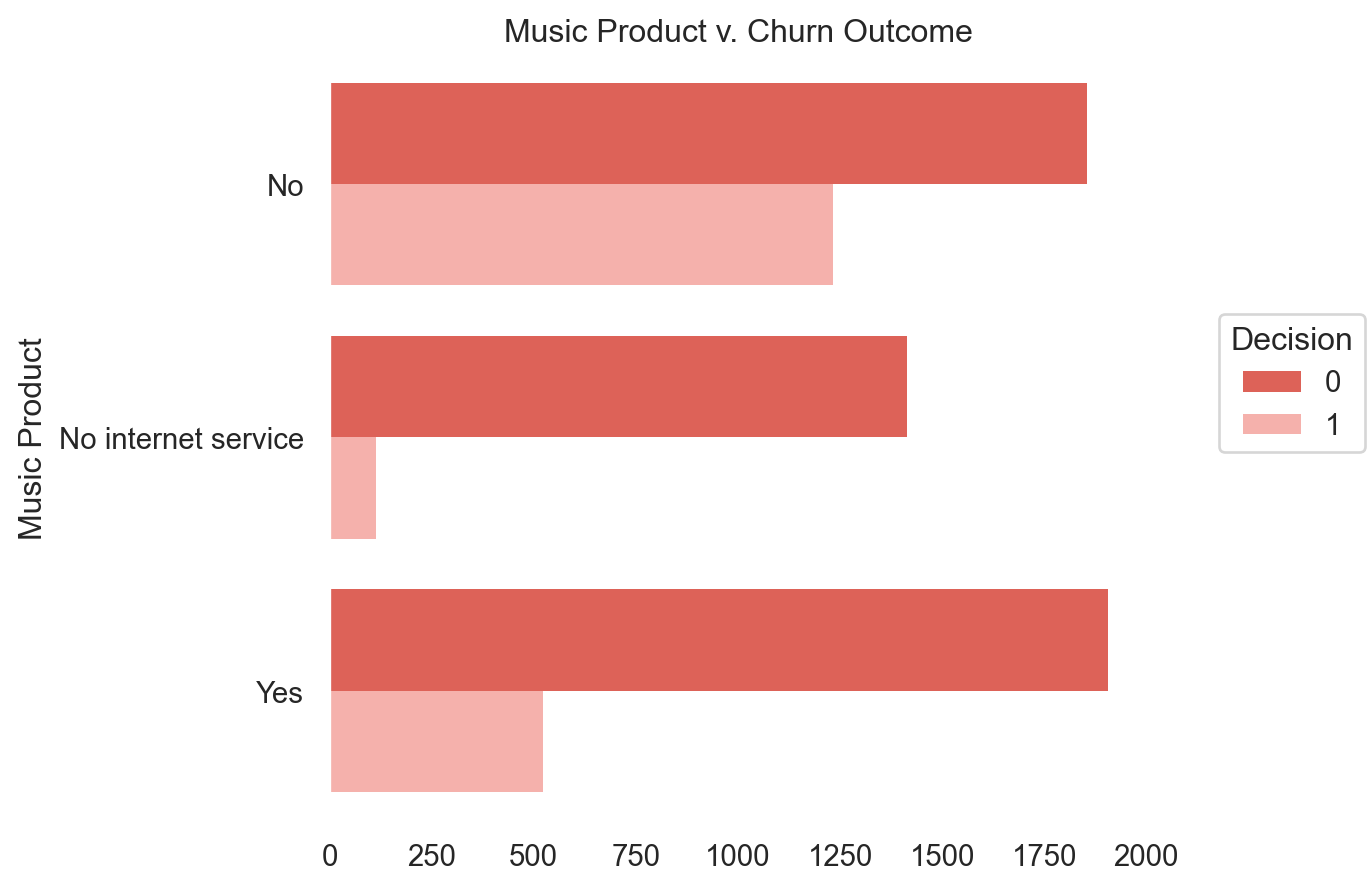

In [72]:
plot_features_label(df, "Music Product")

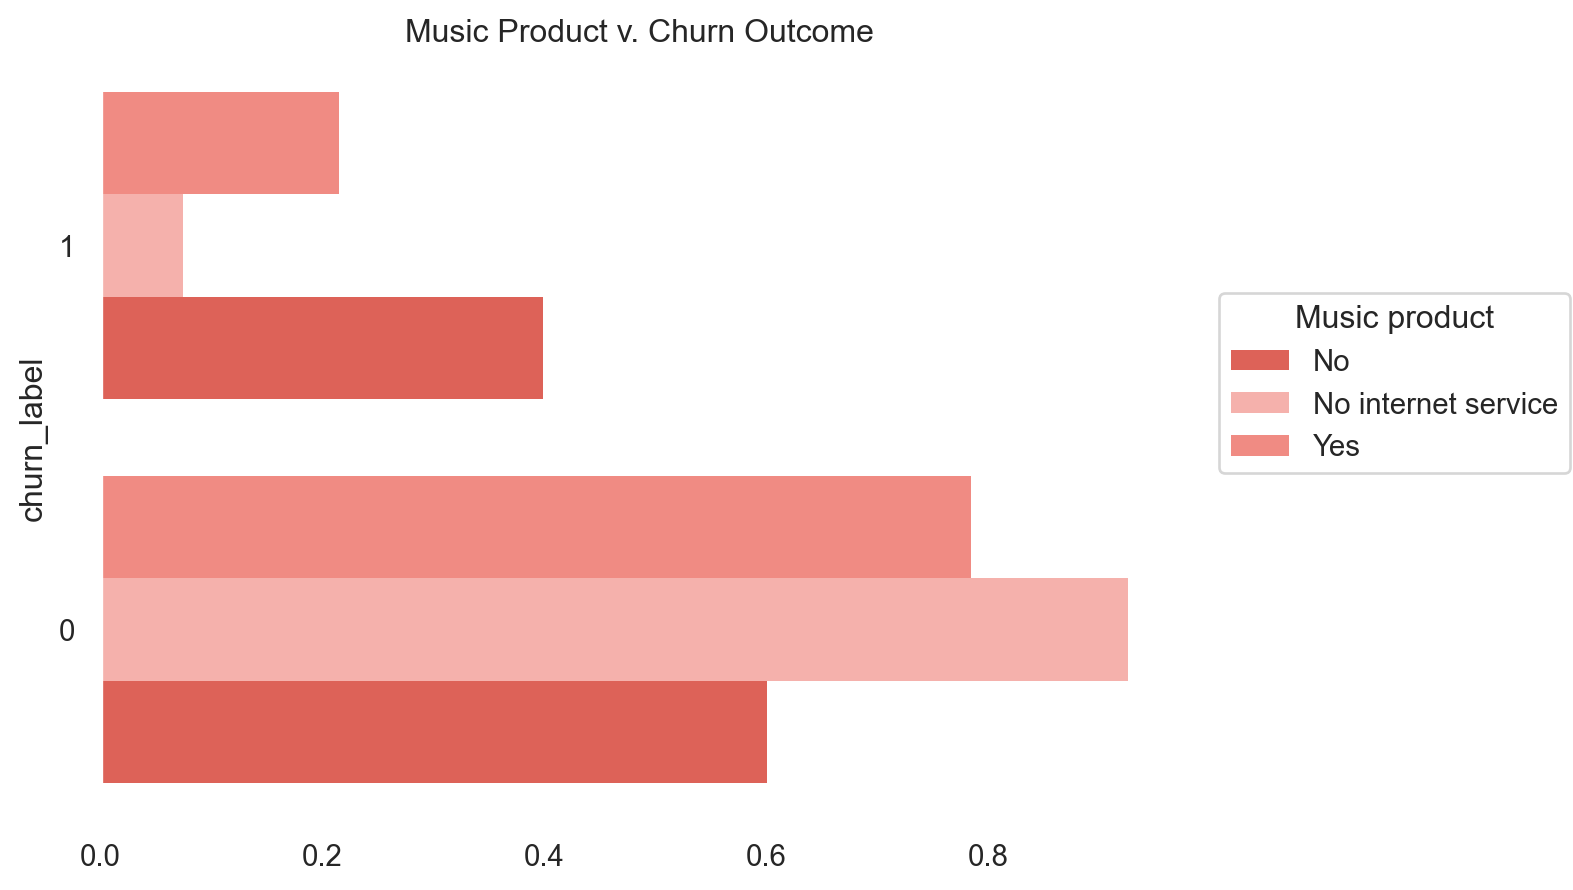

In [73]:
plot_label_features(df, "Music Product")

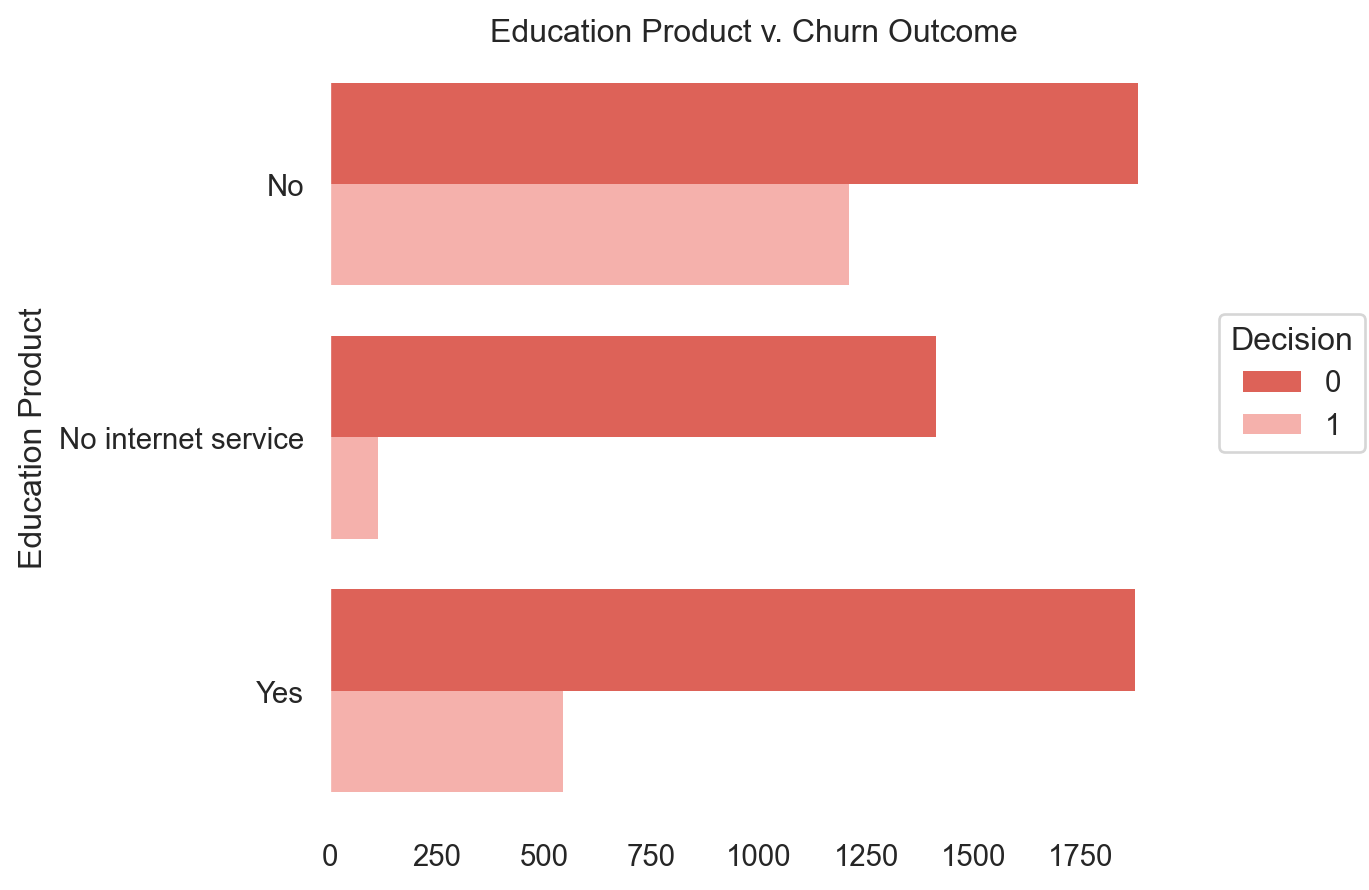

In [74]:
plot_features_label(df, "Education Product")

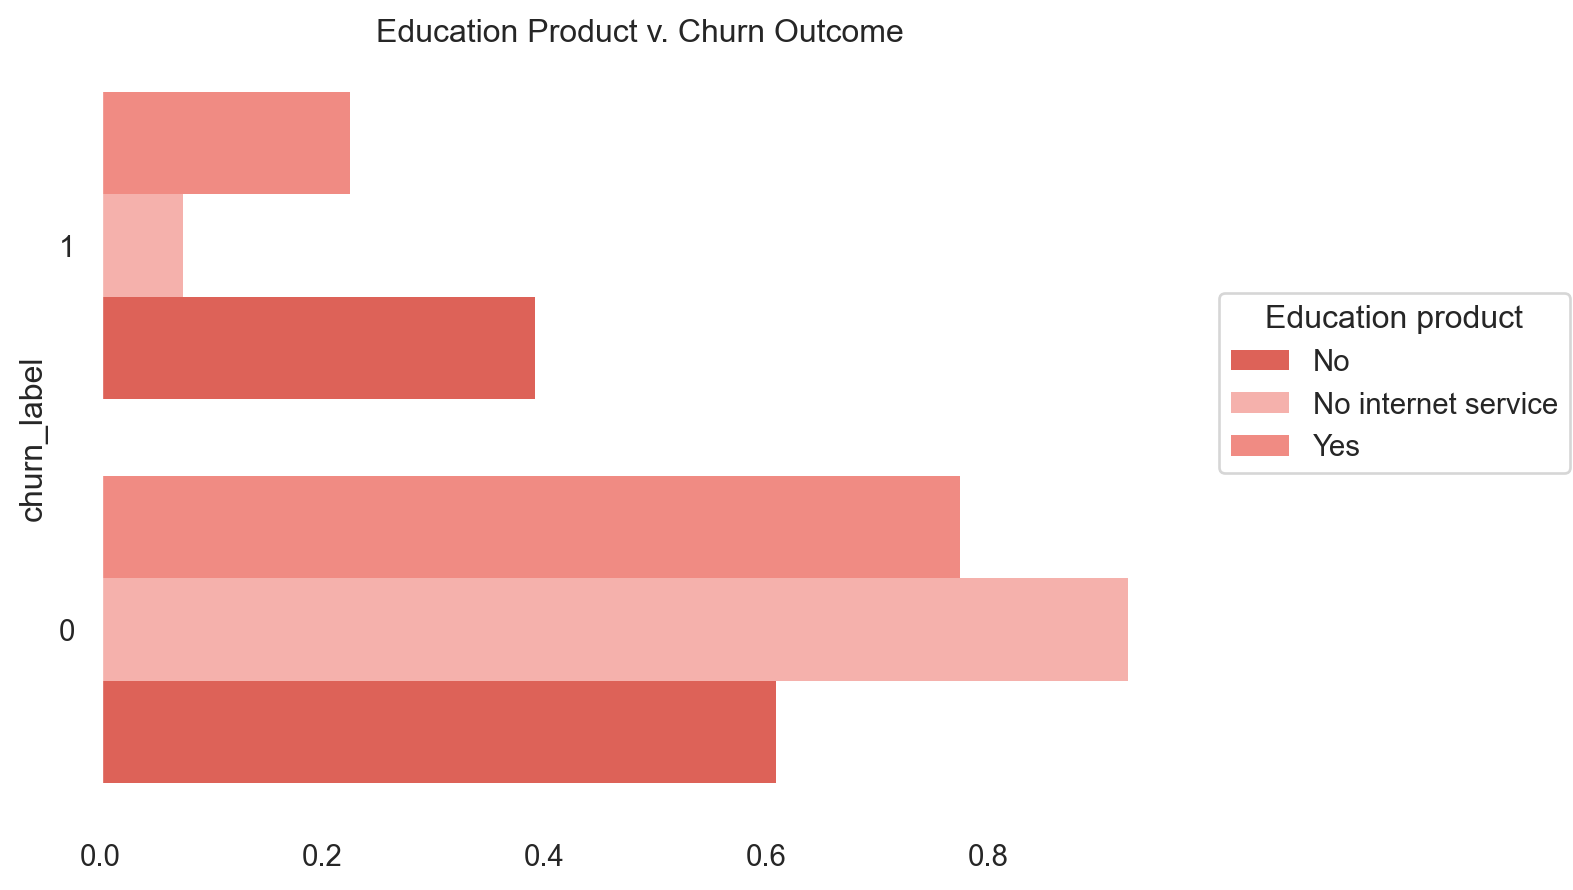

In [75]:
plot_label_features(df, "Education Product")

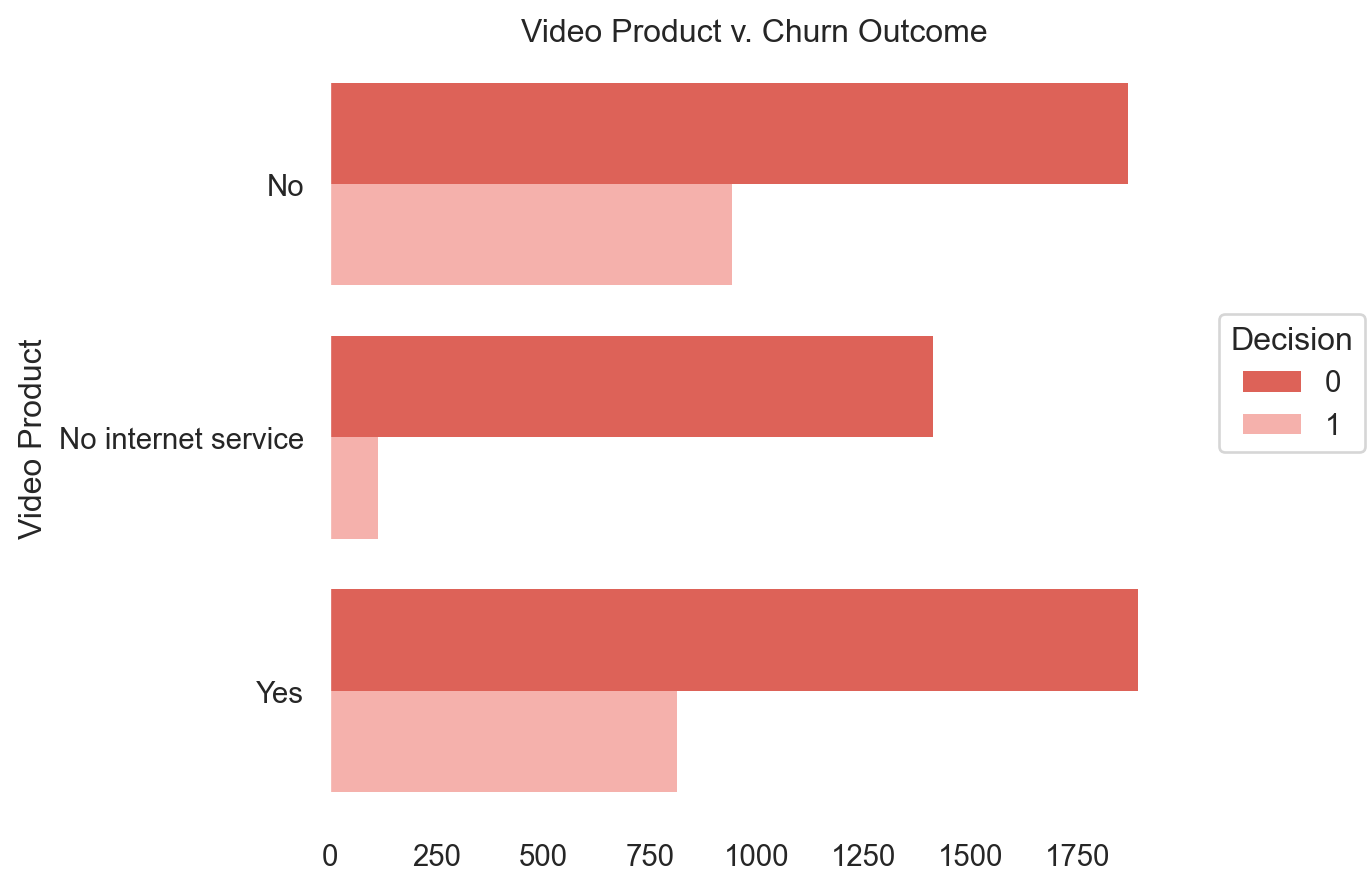

In [76]:
plot_features_label(df, "Video Product")

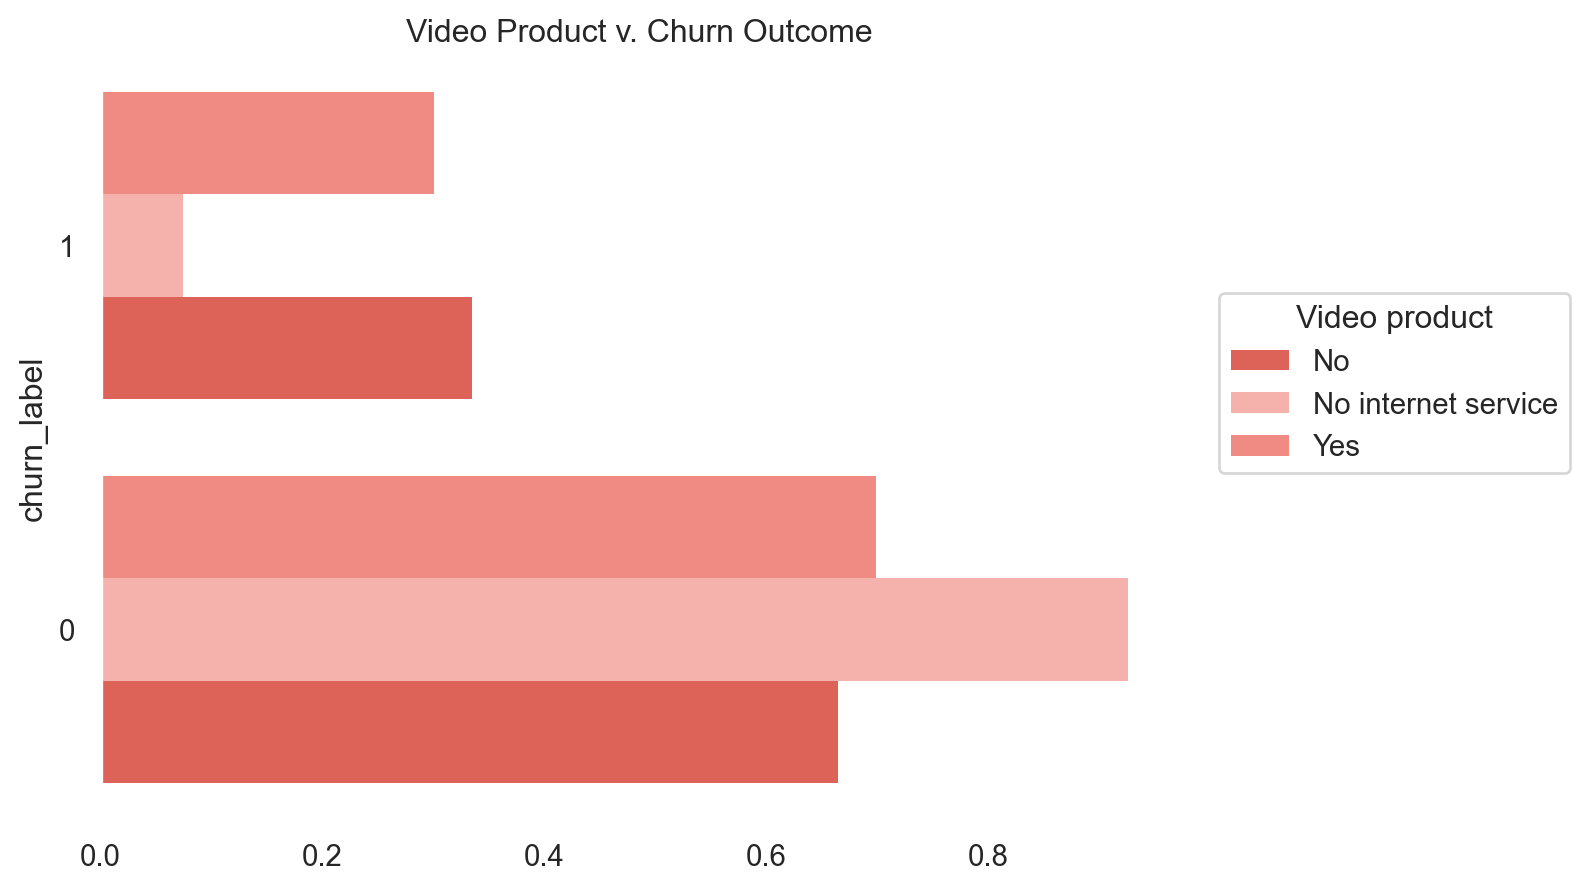

In [77]:
plot_label_features(df, "Video Product")

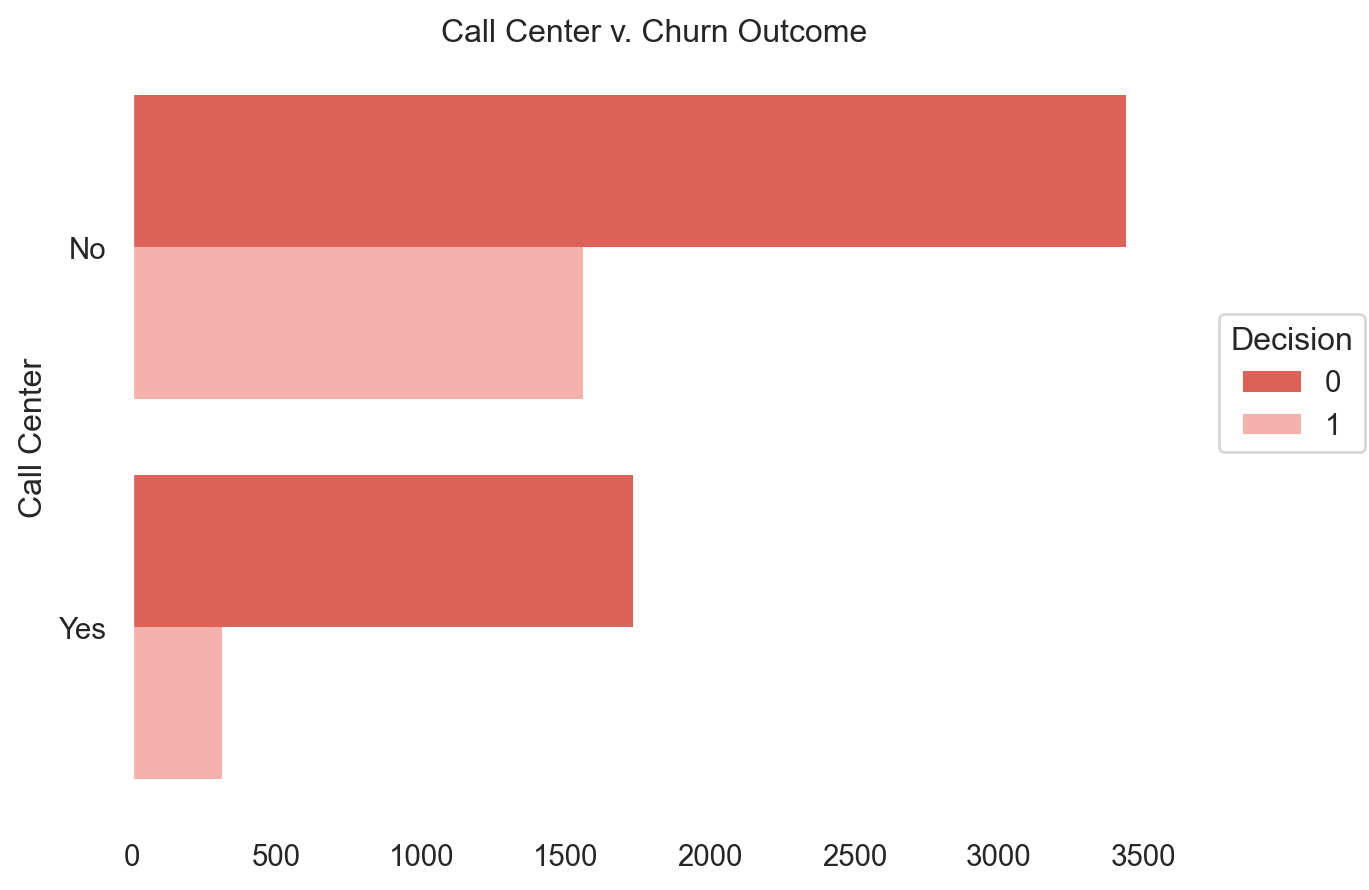

In [78]:
plot_features_label(df, "Call Center")

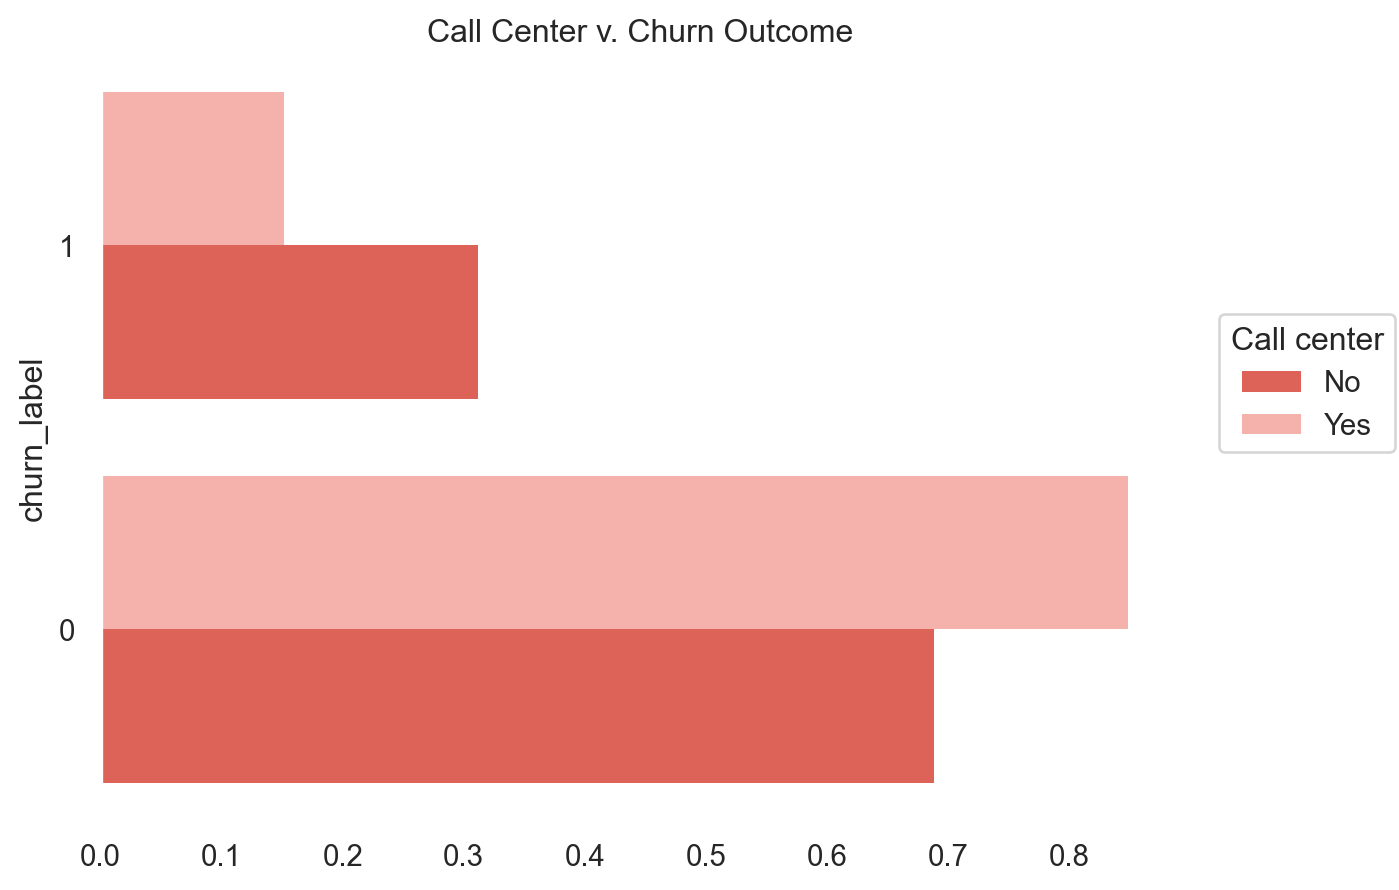

In [79]:
plot_label_features(df, "Call Center")

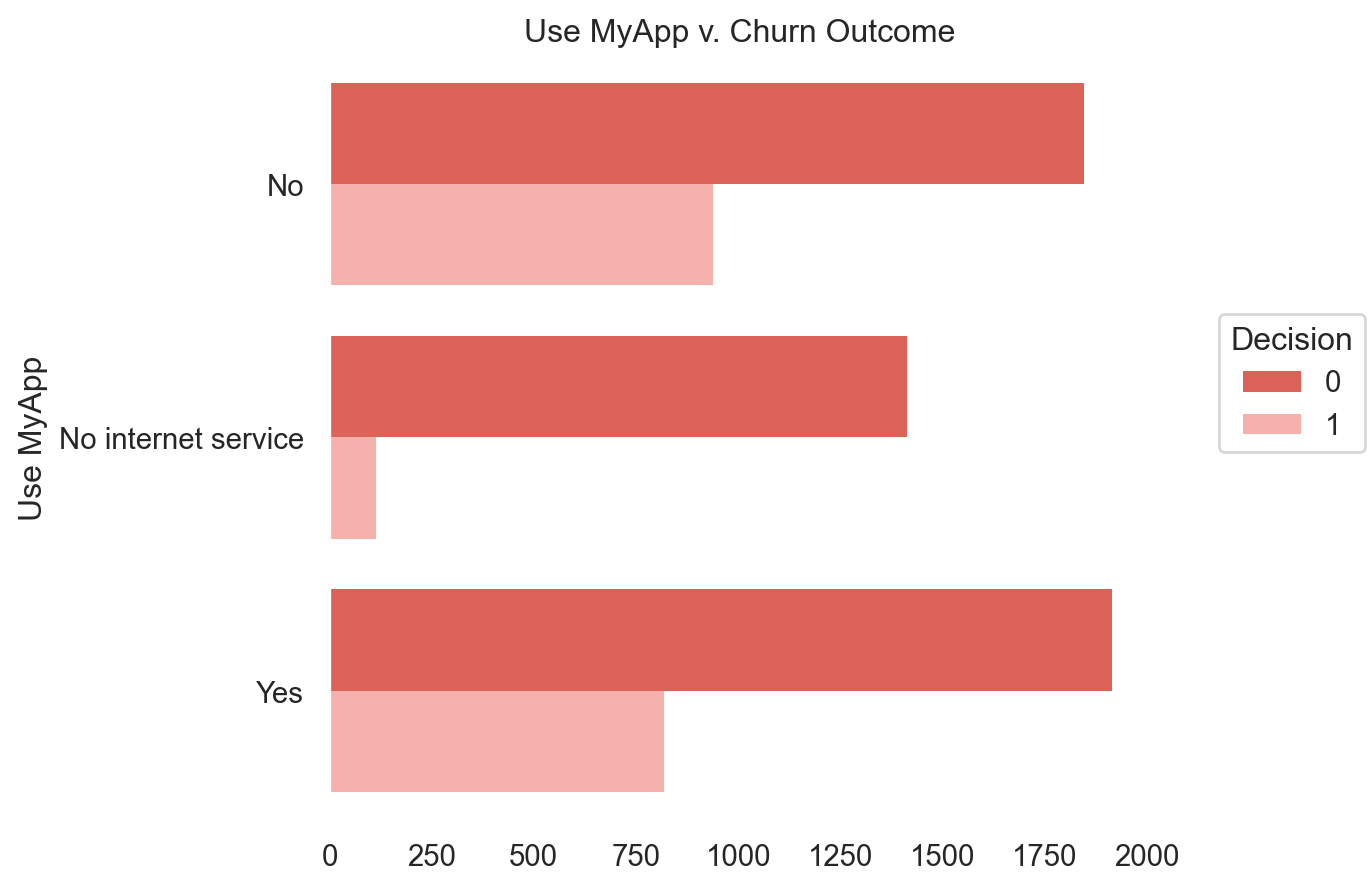

In [80]:
plot_features_label(df, "Use MyApp")

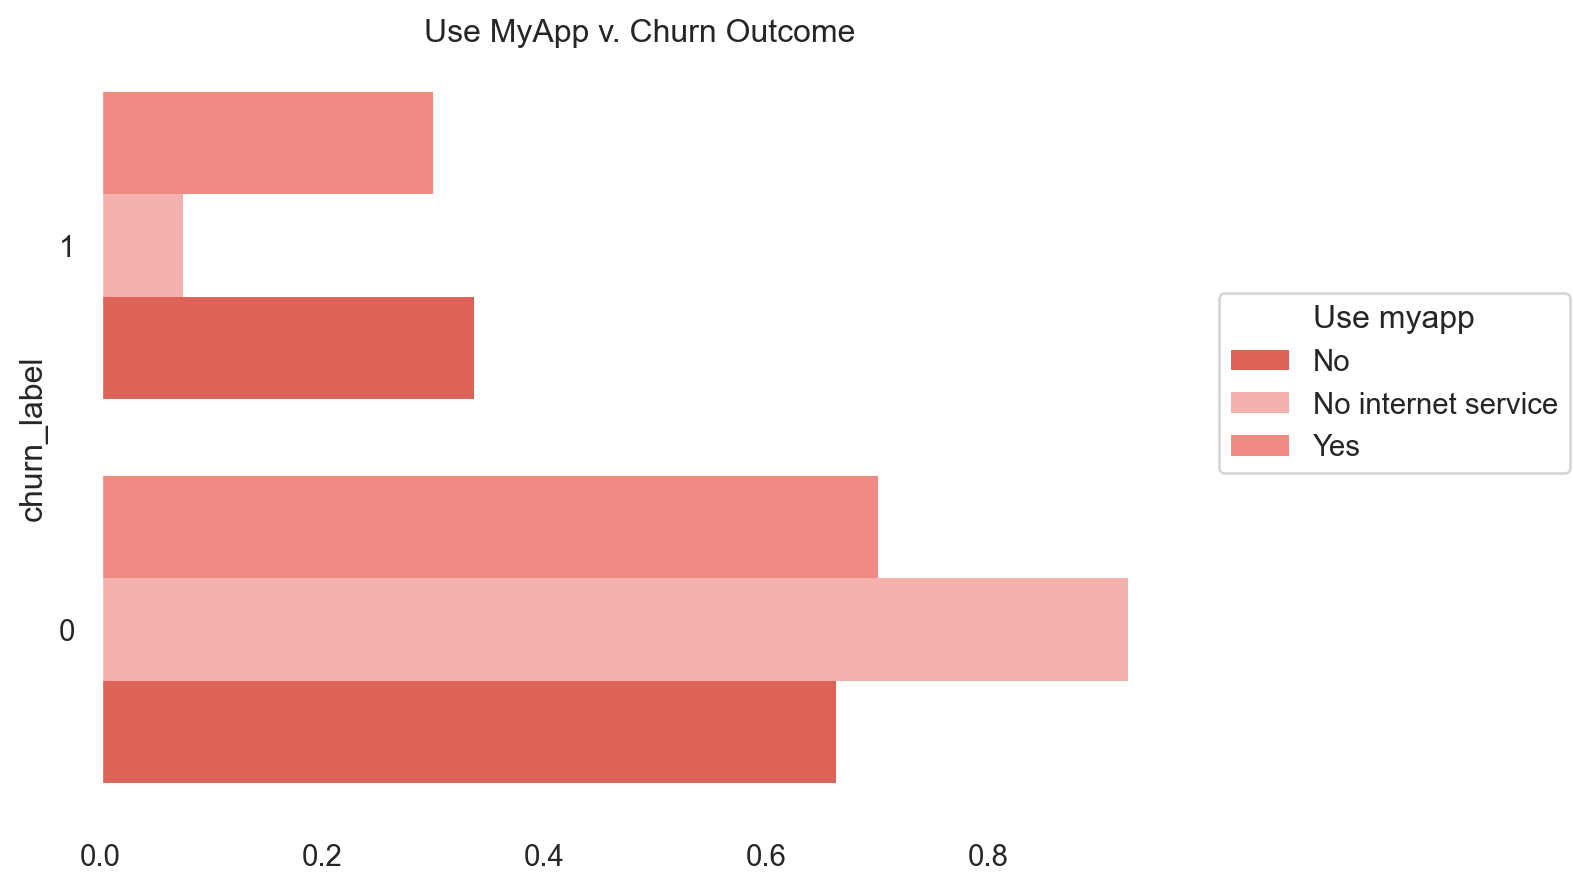

In [81]:
plot_label_features(df, "Use MyApp")

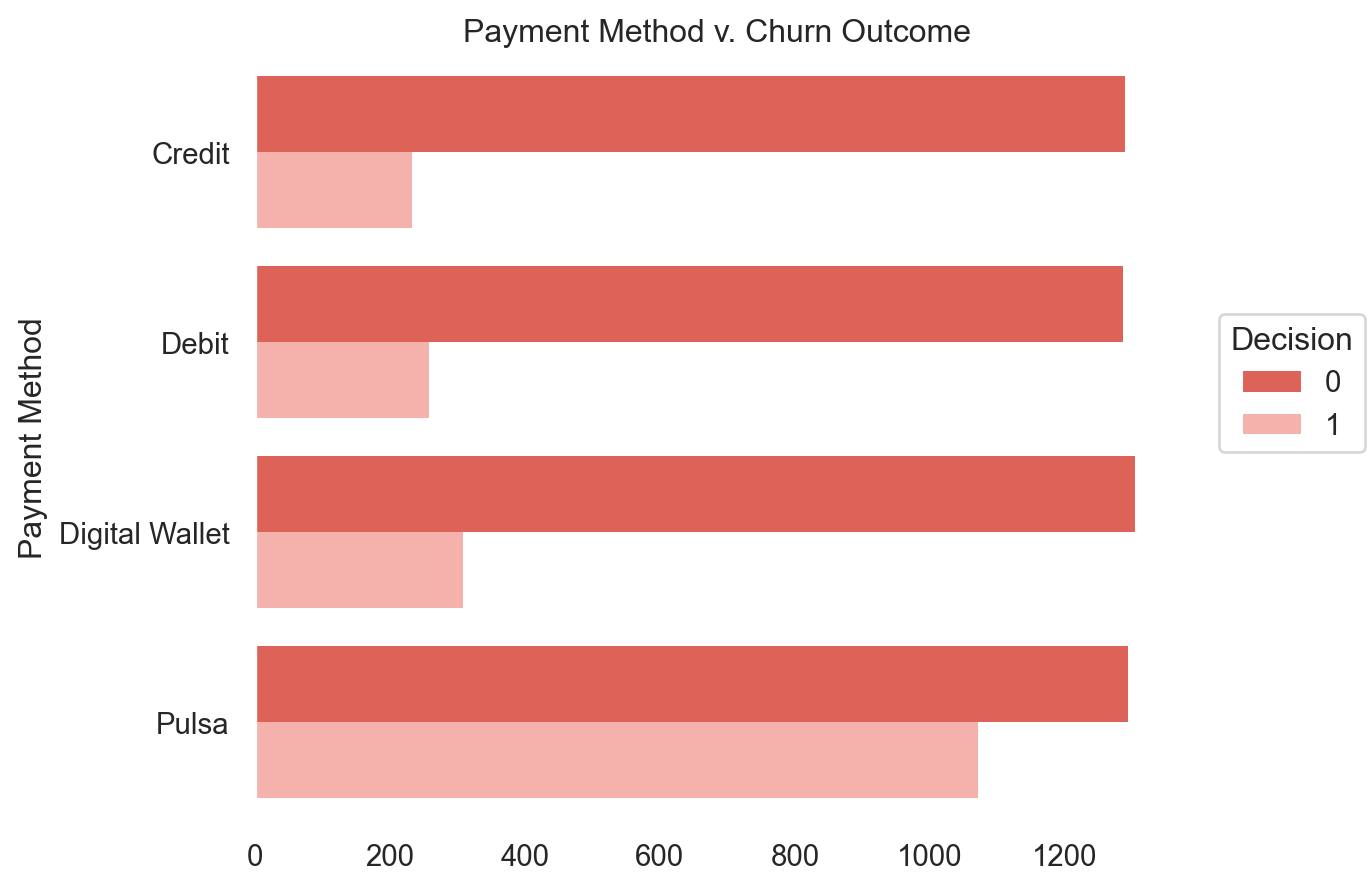

In [82]:
plot_features_label(df, "Payment Method")

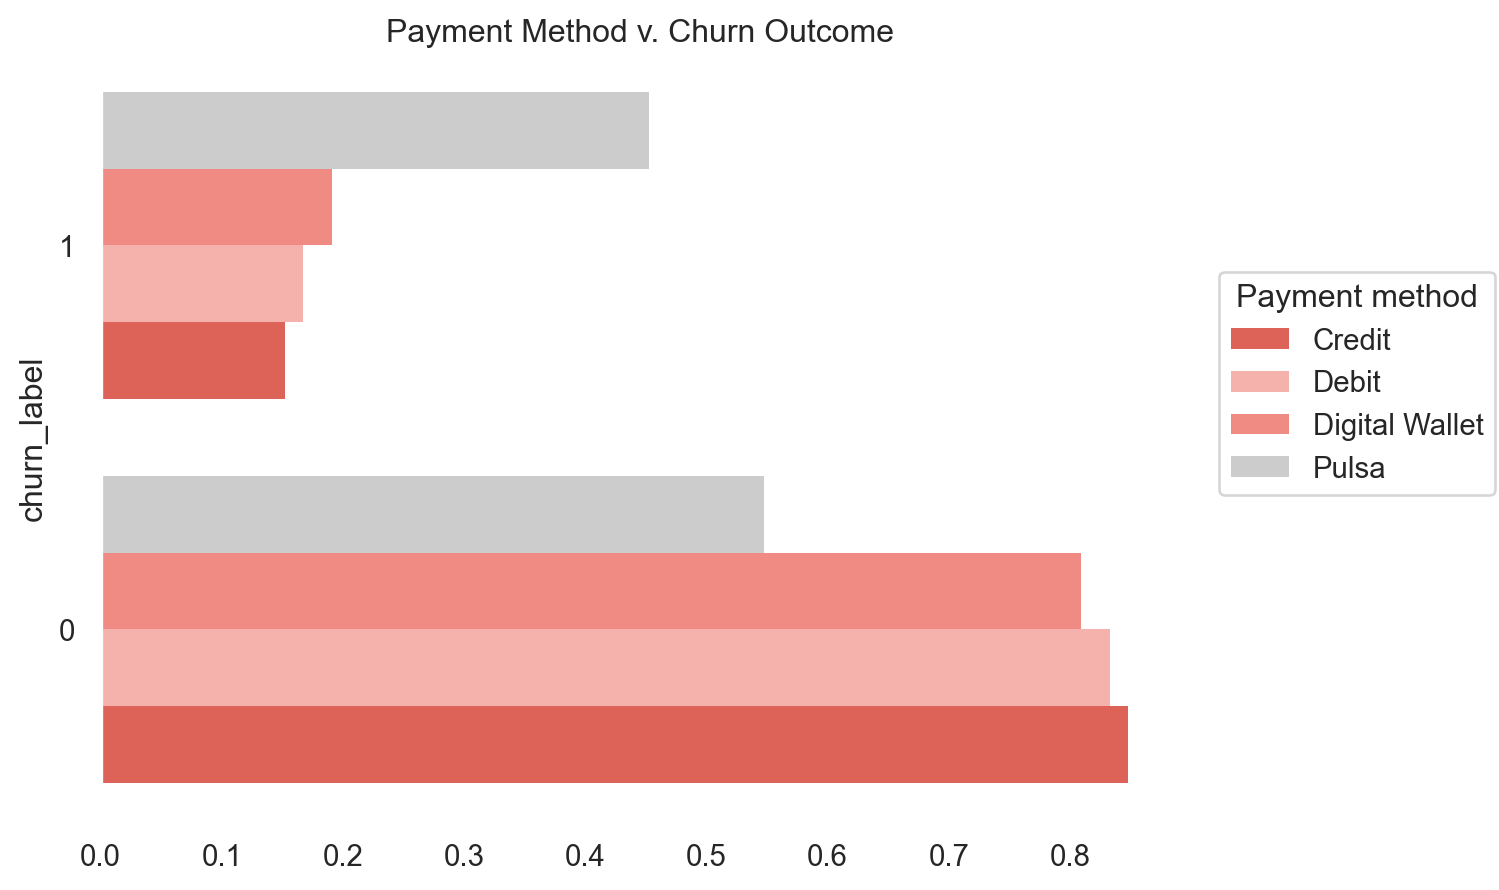

In [83]:
plot_label_features(df, "Payment Method")

<a id='section4_3_3_3'></a>
##### 4.3.3.3. Bivariate Analysis (Relationship between features)

In [84]:
(df
 .info()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Customer ID                   7043 non-null   int64  
 1   Tenure Months                 7043 non-null   int64  
 2   Location                      7043 non-null   object 
 3   Device Class                  7043 non-null   object 
 4   Games Product                 7043 non-null   object 
 5   Music Product                 7043 non-null   object 
 6   Education Product             7043 non-null   object 
 7   Call Center                   7043 non-null   object 
 8   Video Product                 7043 non-null   object 
 9   Use MyApp                     7043 non-null   object 
 10  Payment Method                7043 non-null   object 
 11  Monthly Purchase (Thou. IDR)  7043 non-null   float64
 12  churn_label                   7043 non-null   int64  
 13  Lon

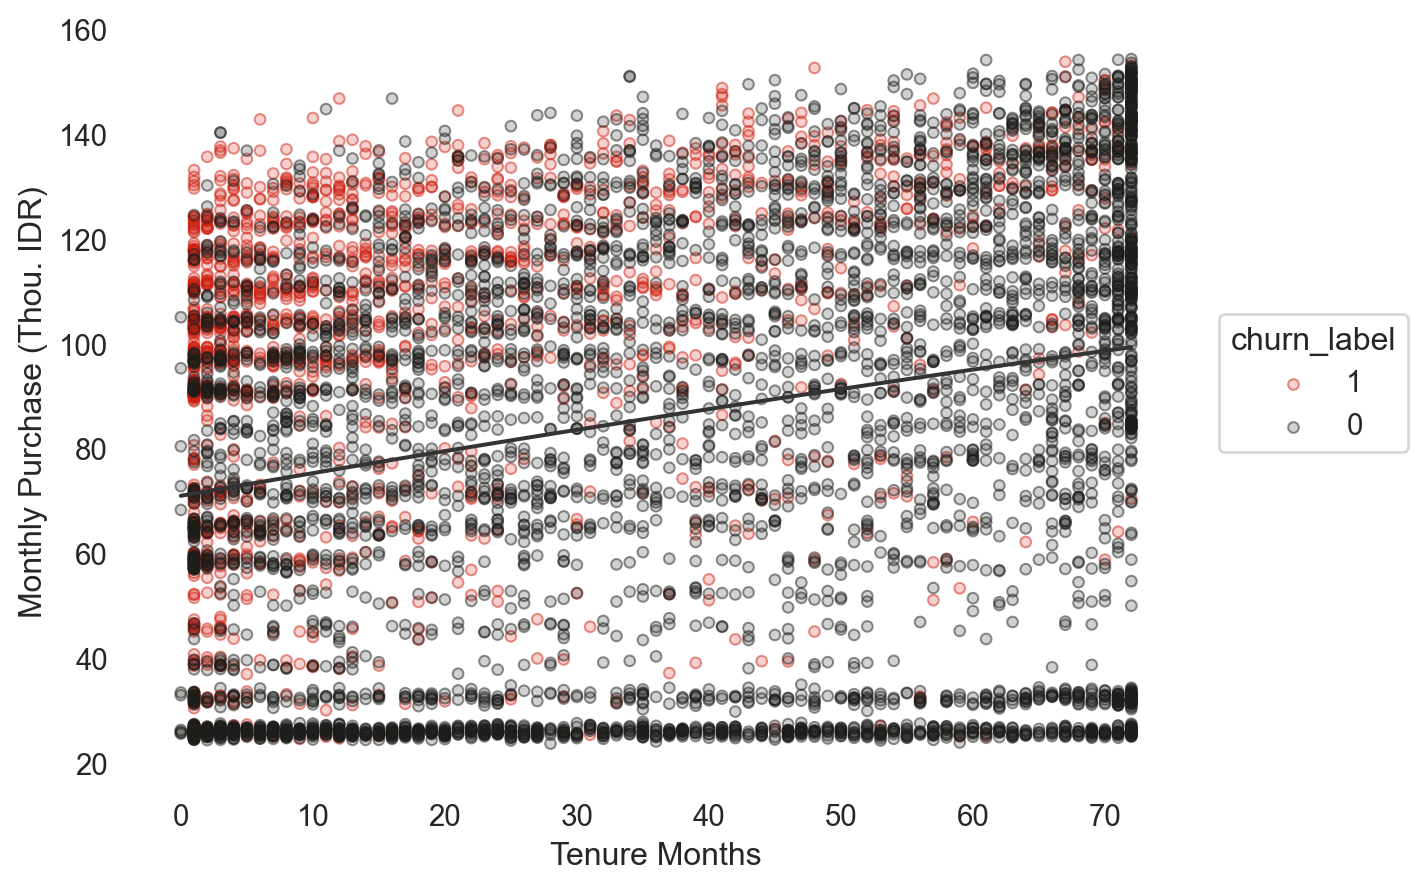

In [85]:
(so
 .Plot((df
        .assign(churn_label=np.where(df.churn_label==0, "0", "1"))),
       x='Tenure Months',
       y='Monthly Purchase (Thou. IDR)')
 .add(so.Dots(alpha=0.5),
      color='churn_label')
 .add(so.Line(color='.2'),
      so.PolyFit(),
      color=None)
 .scale(y=so.Continuous().tick(between=(0, 100)))
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[0], color_palette[7]]), "axes.facecolor": "w", "grid.color": "#ffffff"})
)

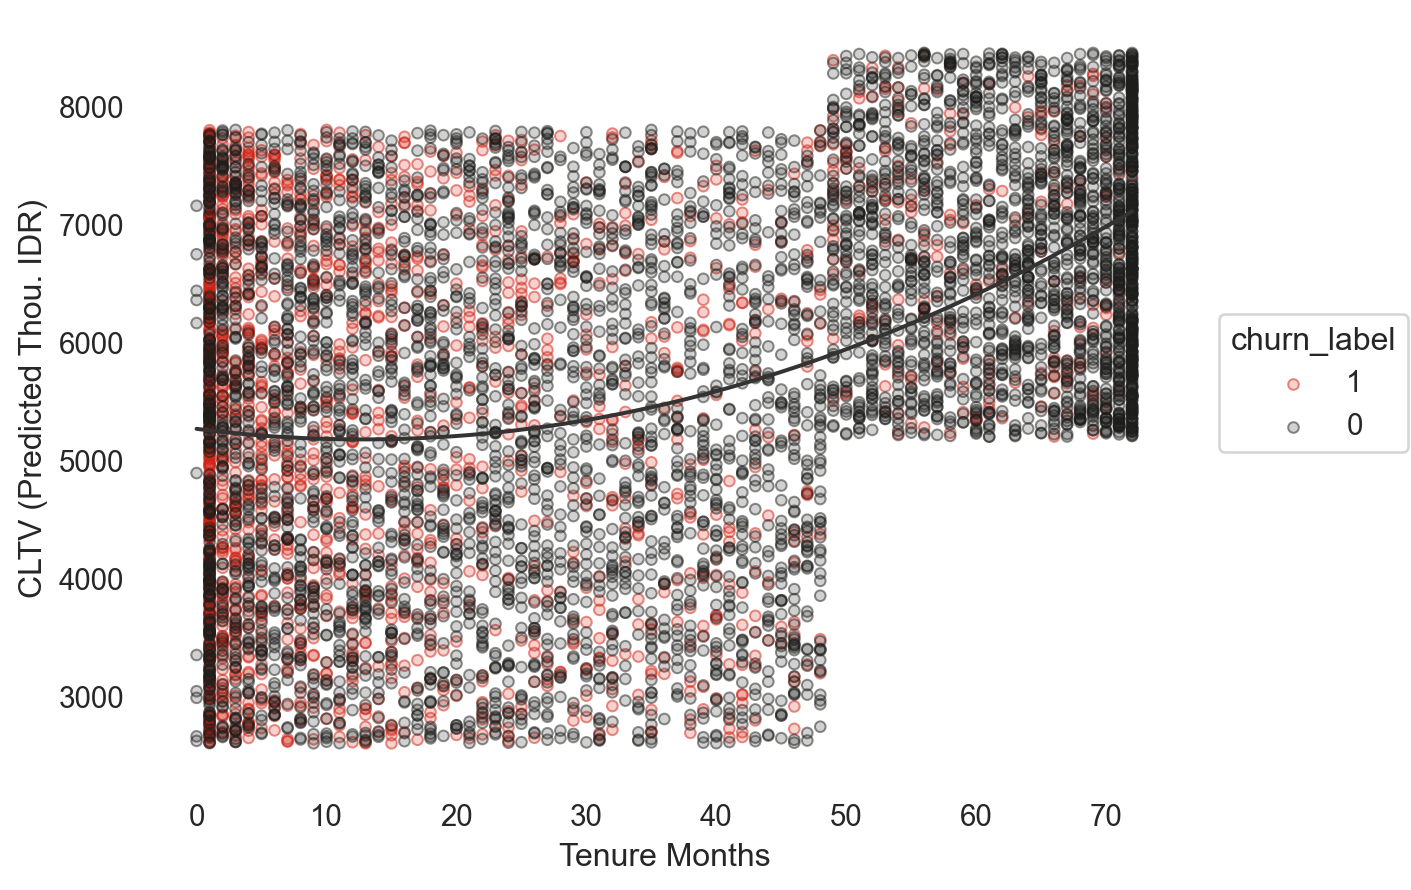

In [86]:
(so
 .Plot((df
        .assign(churn_label=np.where(df.churn_label==0, "0", "1"))),
       x='Tenure Months',
       y='CLTV (Predicted Thou. IDR)')
 .add(so.Dots(alpha=0.5),
      color='churn_label')
 .add(so.Line(color='.2'),
      so.PolyFit(),
      color=None)
 .scale(y=so.Continuous().tick(between=(0, 100)))
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[0], color_palette[7]]), "axes.facecolor": "w", "grid.color": "#ffffff"})
)

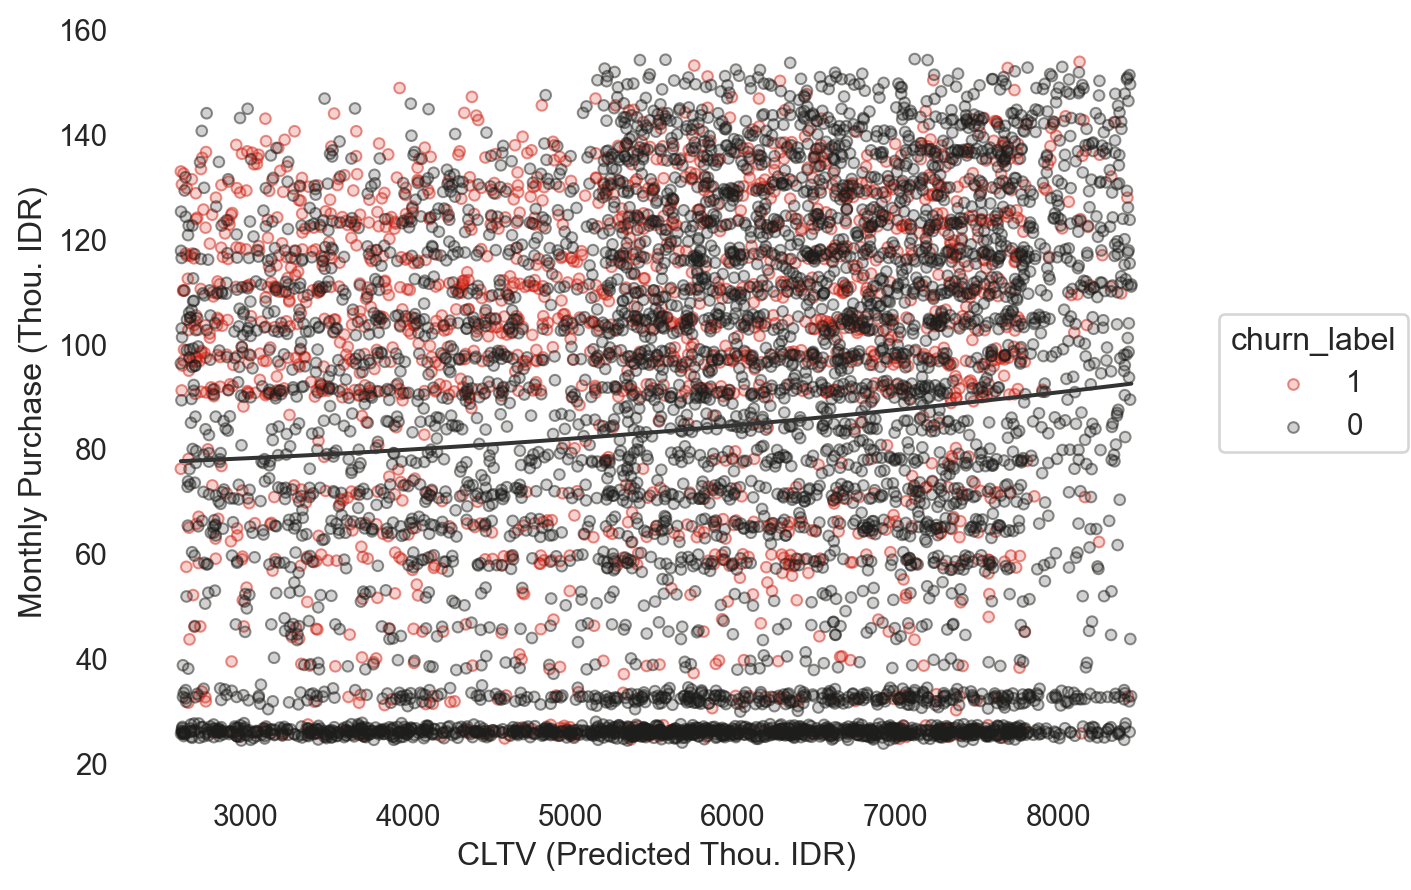

In [87]:
(so
 .Plot((df
        .assign(churn_label=np.where(df.churn_label==0, "0", "1"))),
       x='CLTV (Predicted Thou. IDR)',
       y='Monthly Purchase (Thou. IDR)')
 .add(so.Dots(alpha=0.5),
      color='churn_label')
 .add(so.Line(color='.2'),
      so.PolyFit(),
      color=None)
 .scale(y=so.Continuous().tick(between=(0, 100)))
 .theme({"axes.prop_cycle": matplotlib.cycler(color=[color_palette[0], color_palette[7]]), "axes.facecolor": "w", "grid.color": "#ffffff"})
)

In [88]:
(df
 .groupby(['Location', 'Device Class'])
 ['Device Class']
 .describe()
 ["count"]
 .unstack(level=1)
 .reset_index()
 .melt(id_vars='Location', var_name='Device Class', value_name='count'))

Location Device Class count
0  Bandung     High End   875
1  Jakarta     High End  2221
2  Bandung      Low End   435
3  Jakarta      Low End  1091
4  Bandung      Mid End   702
5  Jakarta      Mid End  1719

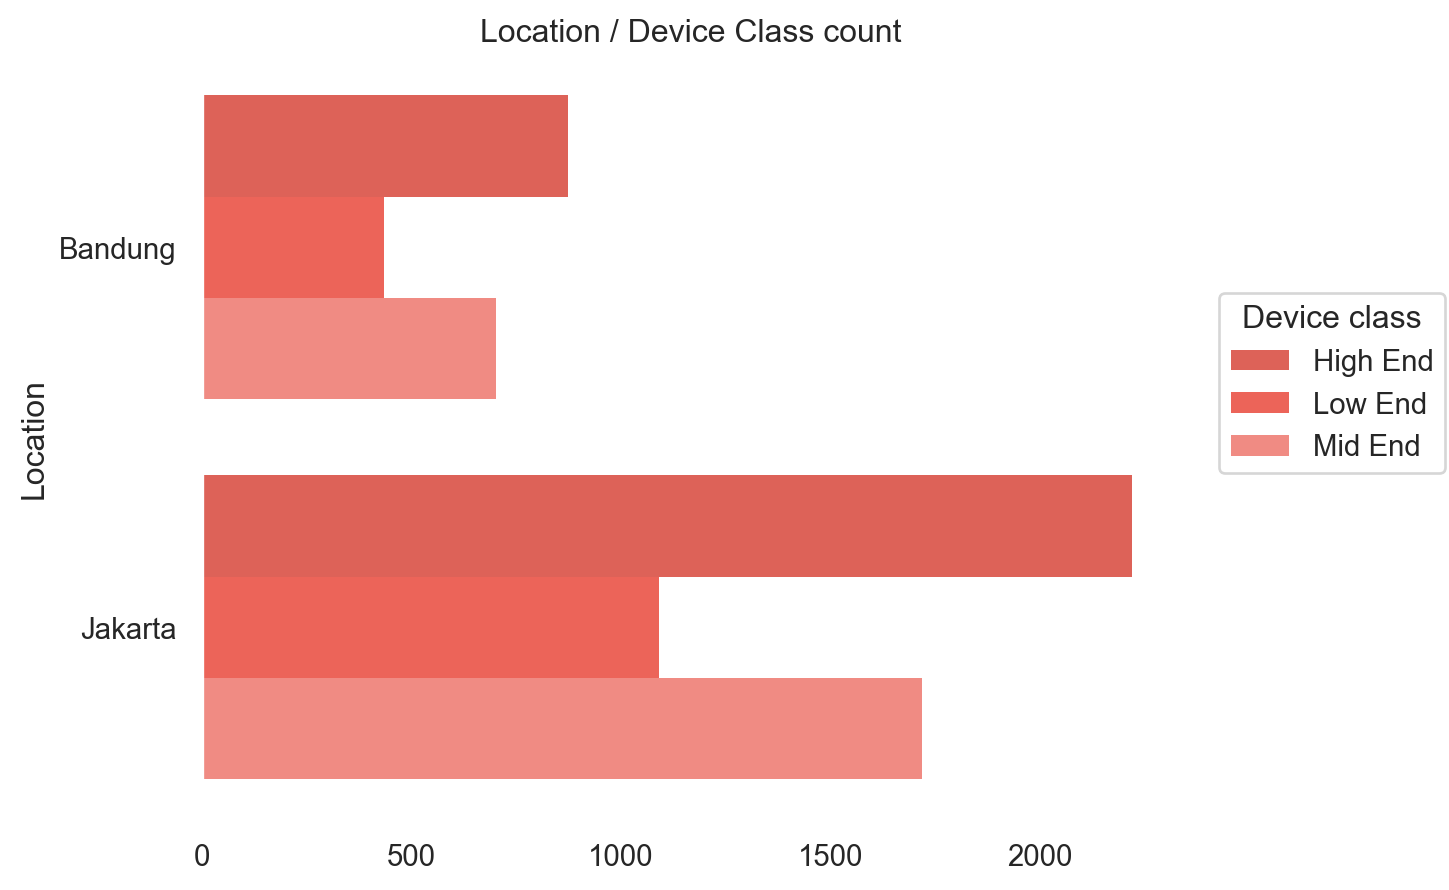

In [89]:
(so
 .Plot((df
 .groupby(['Location', 'Device Class'])
 ['Device Class']
 .describe()
 ["count"]
 .unstack(level=1)
 .reset_index()
 .melt(id_vars='Location', var_name='Device Class', value_name='count')
 .astype({'count': 'int16'})
),
       x='count',
       y='Location',
       color='Device Class')
 .add(so.Bar(edgewidth=0),
      so.Agg(),
      so.Dodge())
 .label(x='',
        y='Location',
        color=str.capitalize,
        title=f'Location / Device Class count')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=color_palette), "axes.facecolor": "w", "grid.color": "#ffffff"})
)

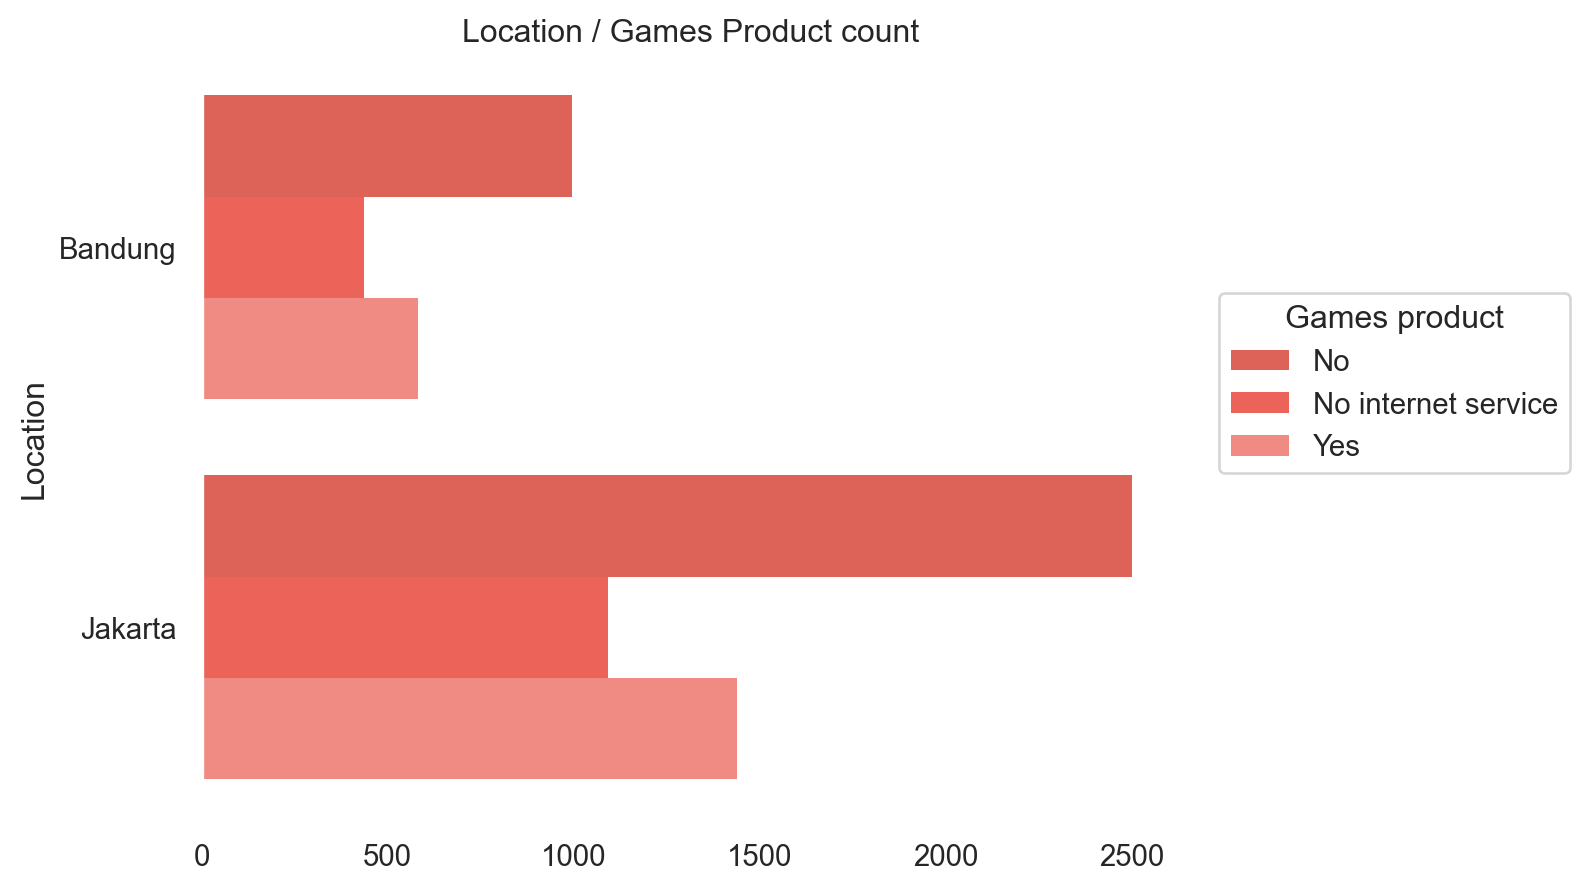

In [90]:
(so
 .Plot((df
 .groupby(['Location', 'Games Product'])
 ['Games Product']
 .describe()
 ["count"]
 .unstack(level=1)
 .reset_index()
 .melt(id_vars='Location', var_name='Games Product', value_name='count')
 .astype({'count': 'int16'})
),
       x='count',
       y='Location',
       color='Games Product')
 .add(so.Bar(edgewidth=0),
      so.Agg(),
      so.Dodge())
 .label(x='',
        y='Location',
        color=str.capitalize,
        title=f'Location / Games Product count')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=color_palette), "axes.facecolor": "w", "grid.color": "#ffffff"})
)

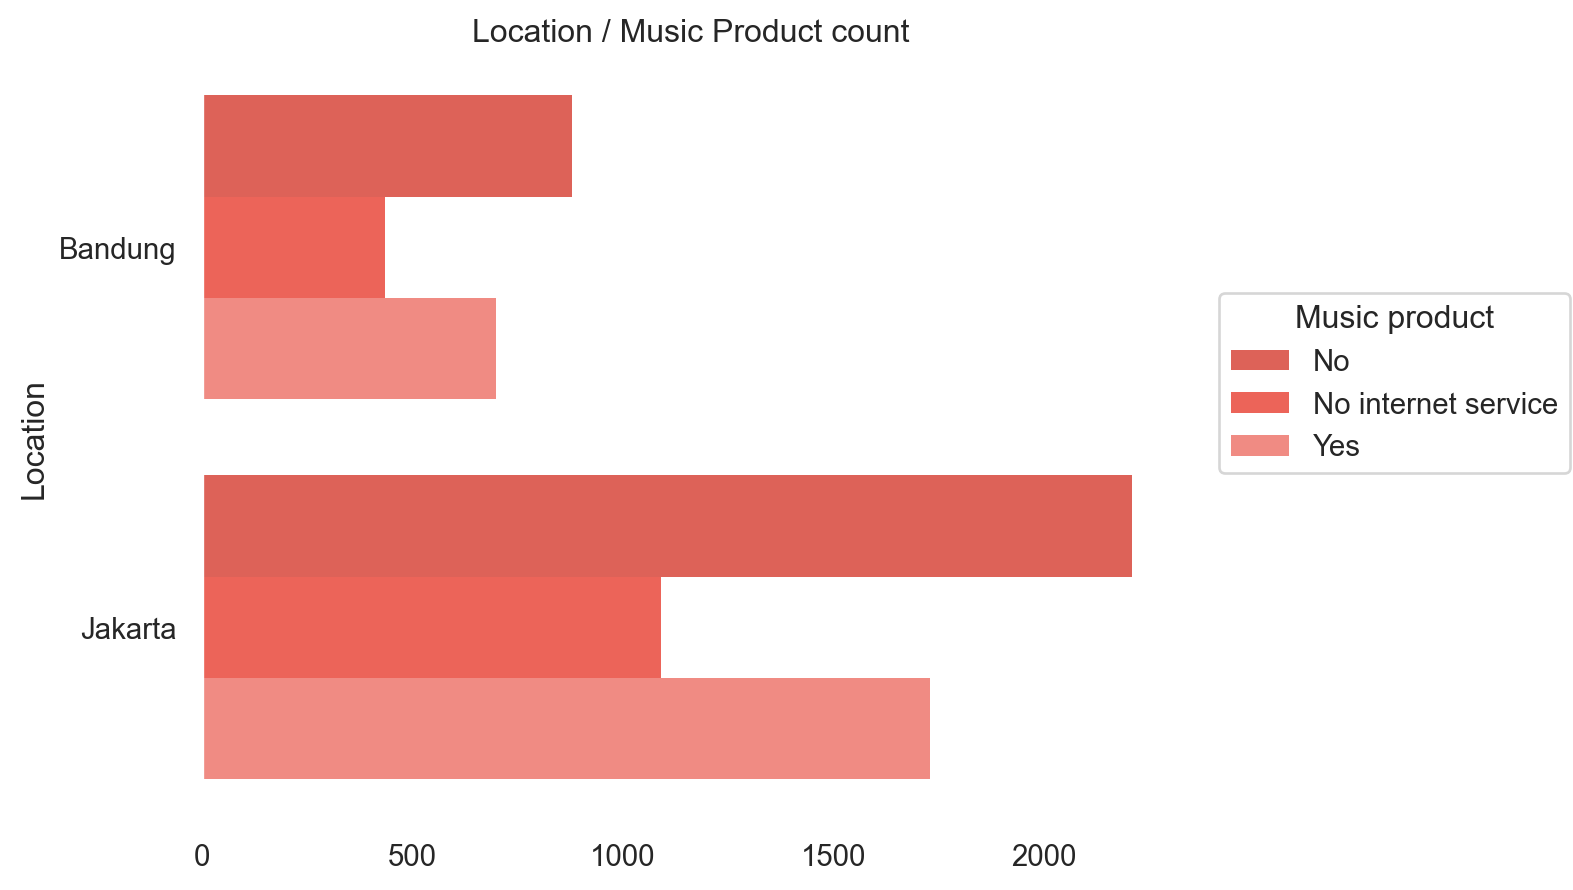

In [91]:
(so
 .Plot((df
 .groupby(['Location', 'Music Product'])
 ['Music Product']
 .describe()
 ["count"]
 .unstack(level=1)
 .reset_index()
 .melt(id_vars='Location', var_name='Music Product', value_name='count')
 .astype({'count': 'int16'})
),
       x='count',
       y='Location',
       color='Music Product')
 .add(so.Bar(edgewidth=0),
      so.Agg(),
      so.Dodge())
 .label(x='',
        y='Location',
        color=str.capitalize,
        title=f'Location / Music Product count')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=color_palette), "axes.facecolor": "w", "grid.color": "#ffffff"})
)

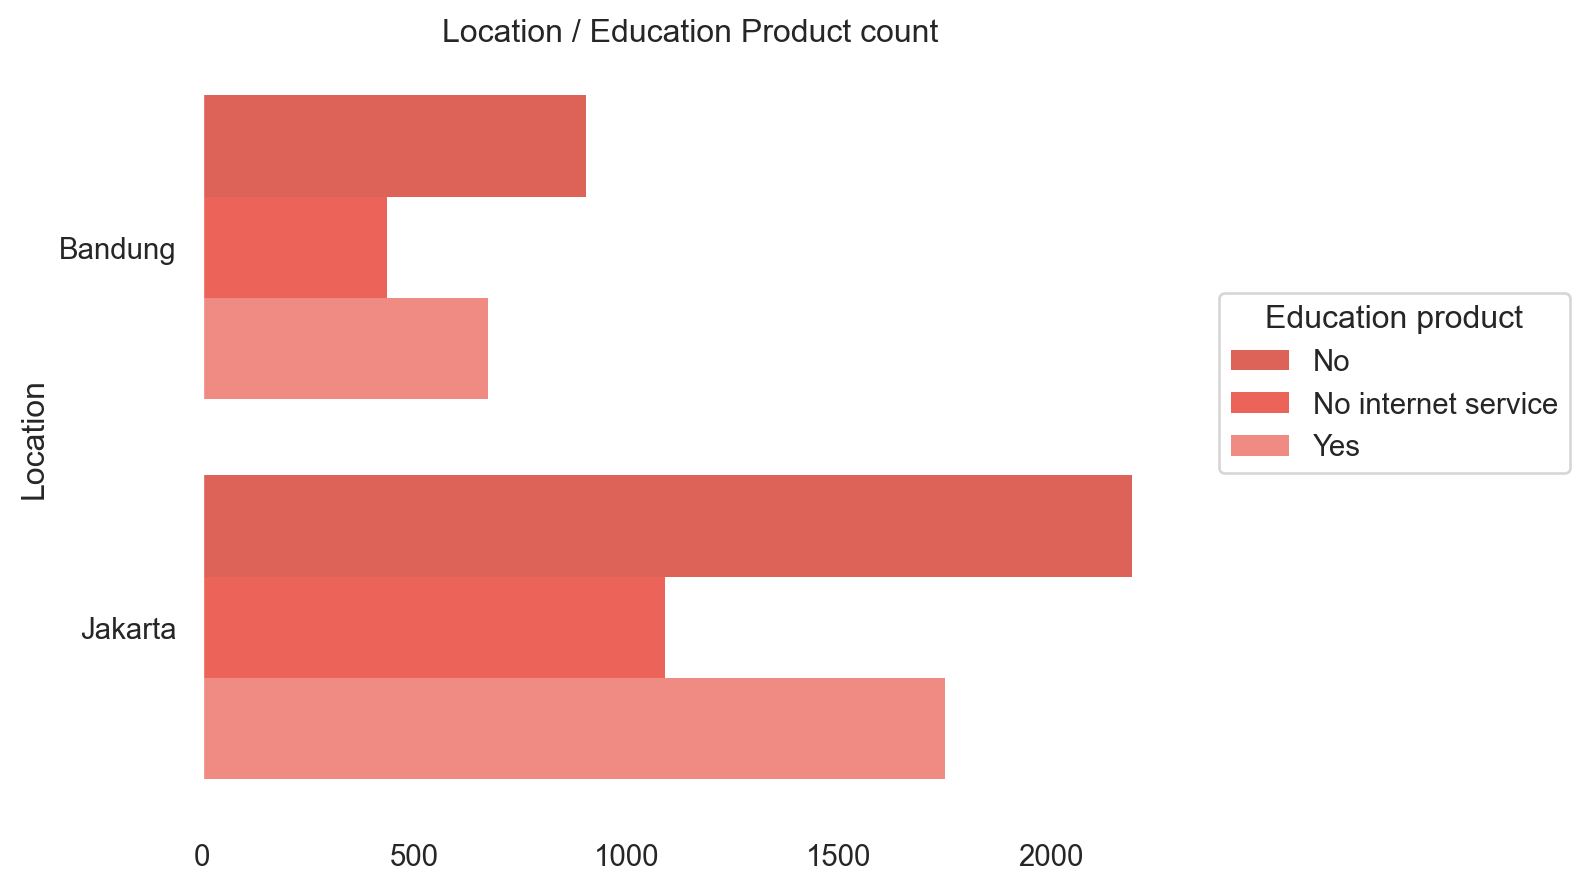

In [92]:
(so
 .Plot((df
 .groupby(['Location', 'Education Product'])
 ['Education Product']
 .describe()
 ["count"]
 .unstack(level=1)
 .reset_index()
 .melt(id_vars='Location', var_name='Education Product', value_name='count')
 .astype({'count': 'int16'})
),
       x='count',
       y='Location',
       color='Education Product')
 .add(so.Bar(edgewidth=0),
      so.Agg(),
      so.Dodge())
 .label(x='',
        y='Location',
        color=str.capitalize,
        title=f'Location / Education Product count')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=color_palette), "axes.facecolor": "w", "grid.color": "#ffffff"})
)

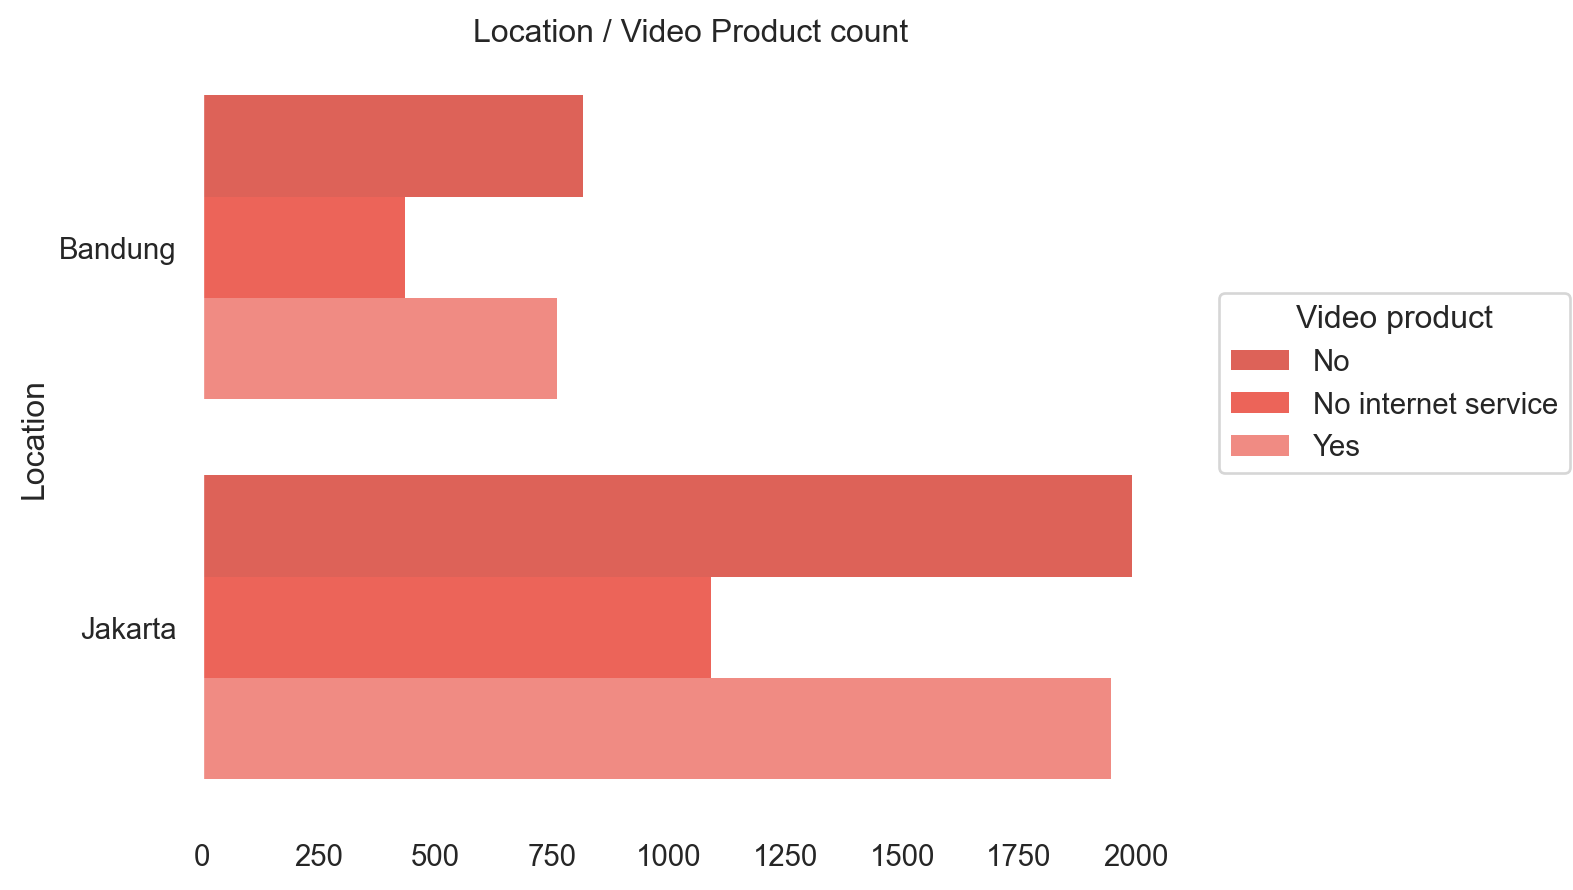

In [93]:
(so
 .Plot((df
 .groupby(['Location', 'Video Product'])
 ['Video Product']
 .describe()
 ["count"]
 .unstack(level=1)
 .reset_index()
 .melt(id_vars='Location', var_name='Video Product', value_name='count')
 .astype({'count': 'int16'})
),
       x='count',
       y='Location',
       color='Video Product')
 .add(so.Bar(edgewidth=0),
      so.Agg(),
      so.Dodge())
 .label(x='',
        y='Location',
        color=str.capitalize,
        title=f'Location / Video Product count')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=color_palette), "axes.facecolor": "w", "grid.color": "#ffffff"})
)

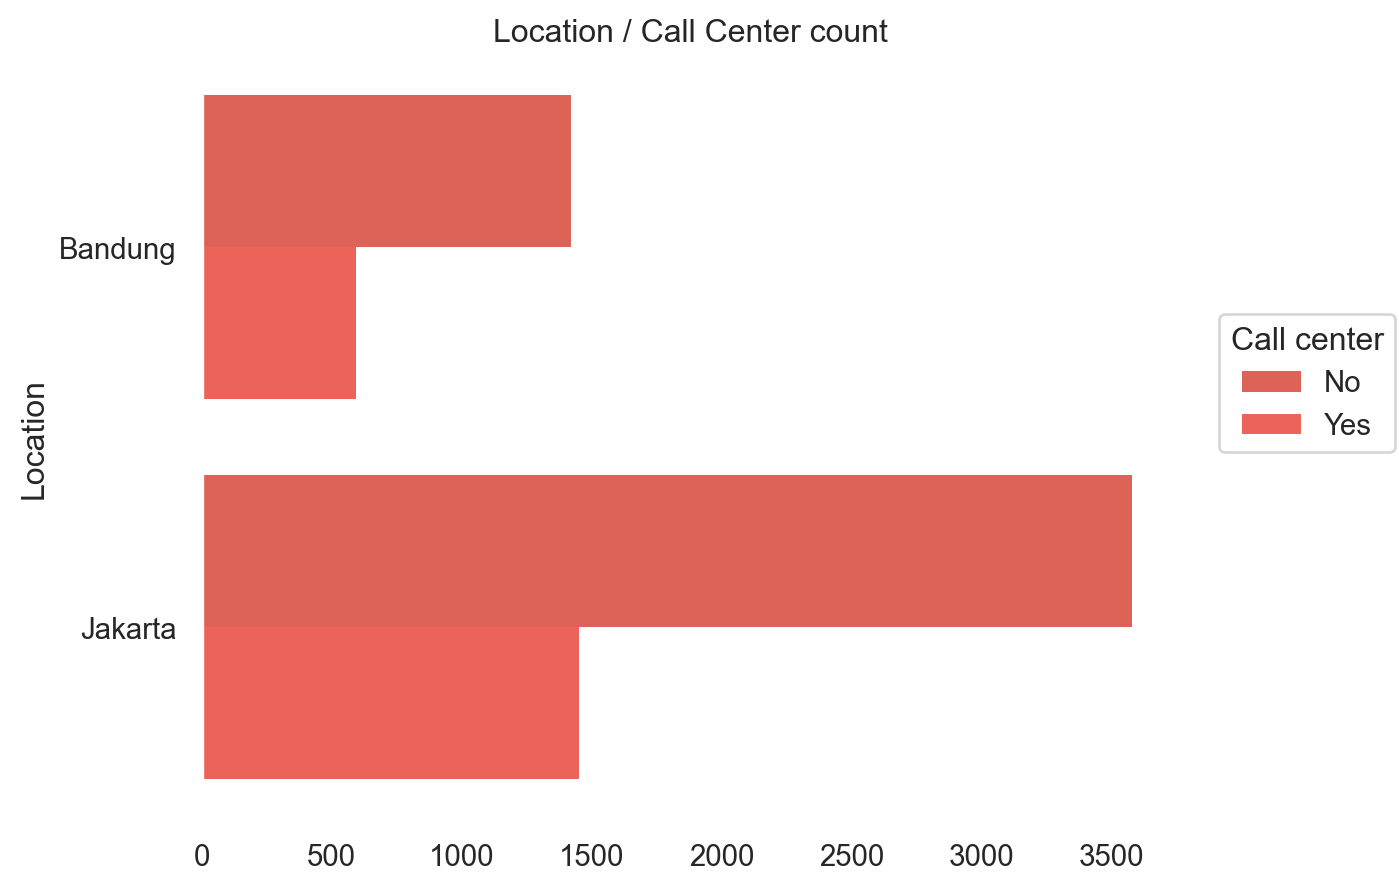

In [94]:
(so
 .Plot((df
 .groupby(['Location', 'Call Center'])
 ['Call Center']
 .describe()
 ["count"]
 .unstack(level=1)
 .reset_index()
 .melt(id_vars='Location', var_name='Call Center', value_name='count')
 .astype({'count': 'int16'})
),
       x='count',
       y='Location',
       color='Call Center')
 .add(so.Bar(edgewidth=0),
      so.Agg(),
      so.Dodge())
 .label(x='',
        y='Location',
        color=str.capitalize,
        title=f'Location / Call Center count')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=color_palette), "axes.facecolor": "w", "grid.color": "#ffffff"})
)

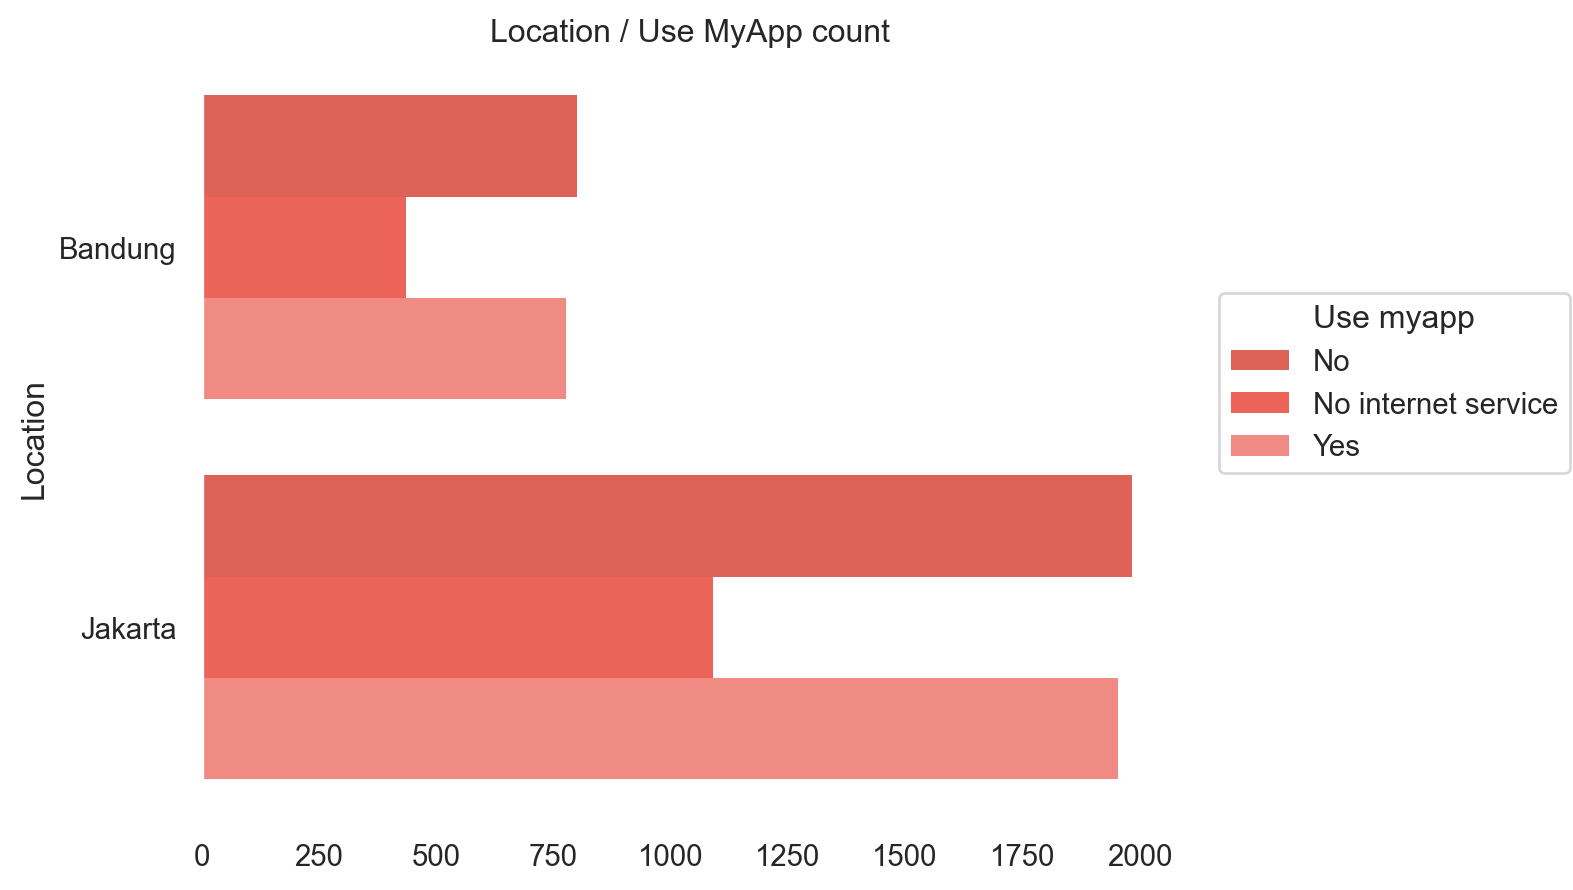

In [95]:
(so
 .Plot((df
 .groupby(['Location', 'Use MyApp'])
 ['Use MyApp']
 .describe()
 ["count"]
 .unstack(level=1)
 .reset_index()
 .melt(id_vars='Location', var_name='Use MyApp', value_name='count')
 .astype({'count': 'int16'})
),
       x='count',
       y='Location',
       color='Use MyApp')
 .add(so.Bar(edgewidth=0),
      so.Agg(),
      so.Dodge())
 .label(x='',
        y='Location',
        color=str.capitalize,
        title=f'Location / Use MyApp count')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=color_palette), "axes.facecolor": "w", "grid.color": "#ffffff"})
)

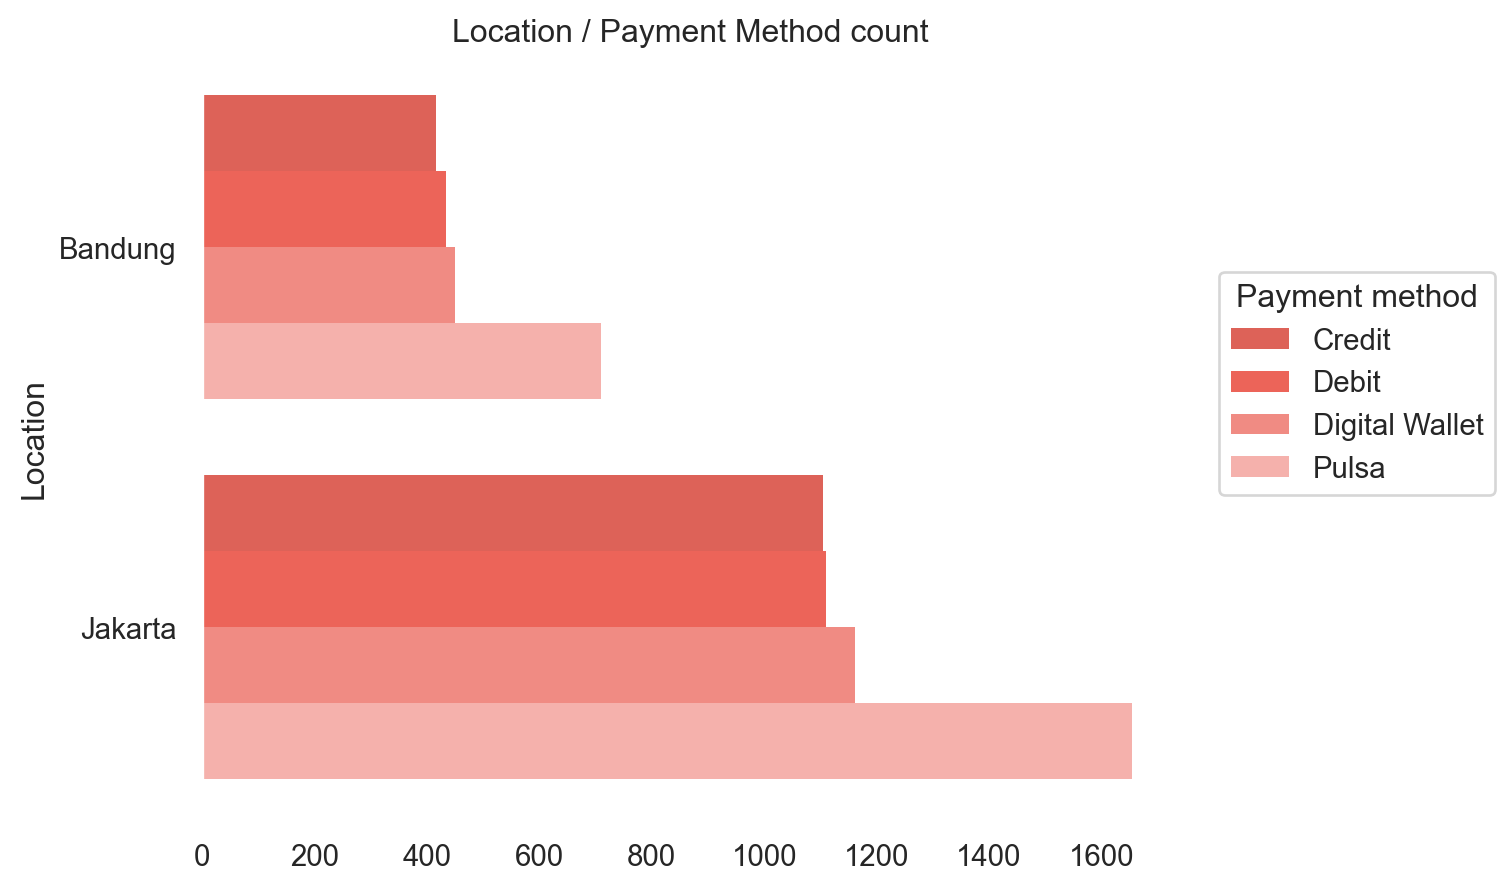

In [96]:
(so
 .Plot((df
 .groupby(['Location', 'Payment Method'])
 ['Payment Method']
 .describe()
 ["count"]
 .unstack(level=1)
 .reset_index()
 .melt(id_vars='Location', var_name='Payment Method', value_name='count')
 .astype({'count': 'int16'})
),
       x='count',
       y='Location',
       color='Payment Method')
 .add(so.Bar(edgewidth=0),
      so.Agg(),
      so.Dodge())
 .label(x='',
        y='Location',
        color=str.capitalize,
        title=f'Location / Payment Method count')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=color_palette), "axes.facecolor": "w", "grid.color": "#ffffff"})
)

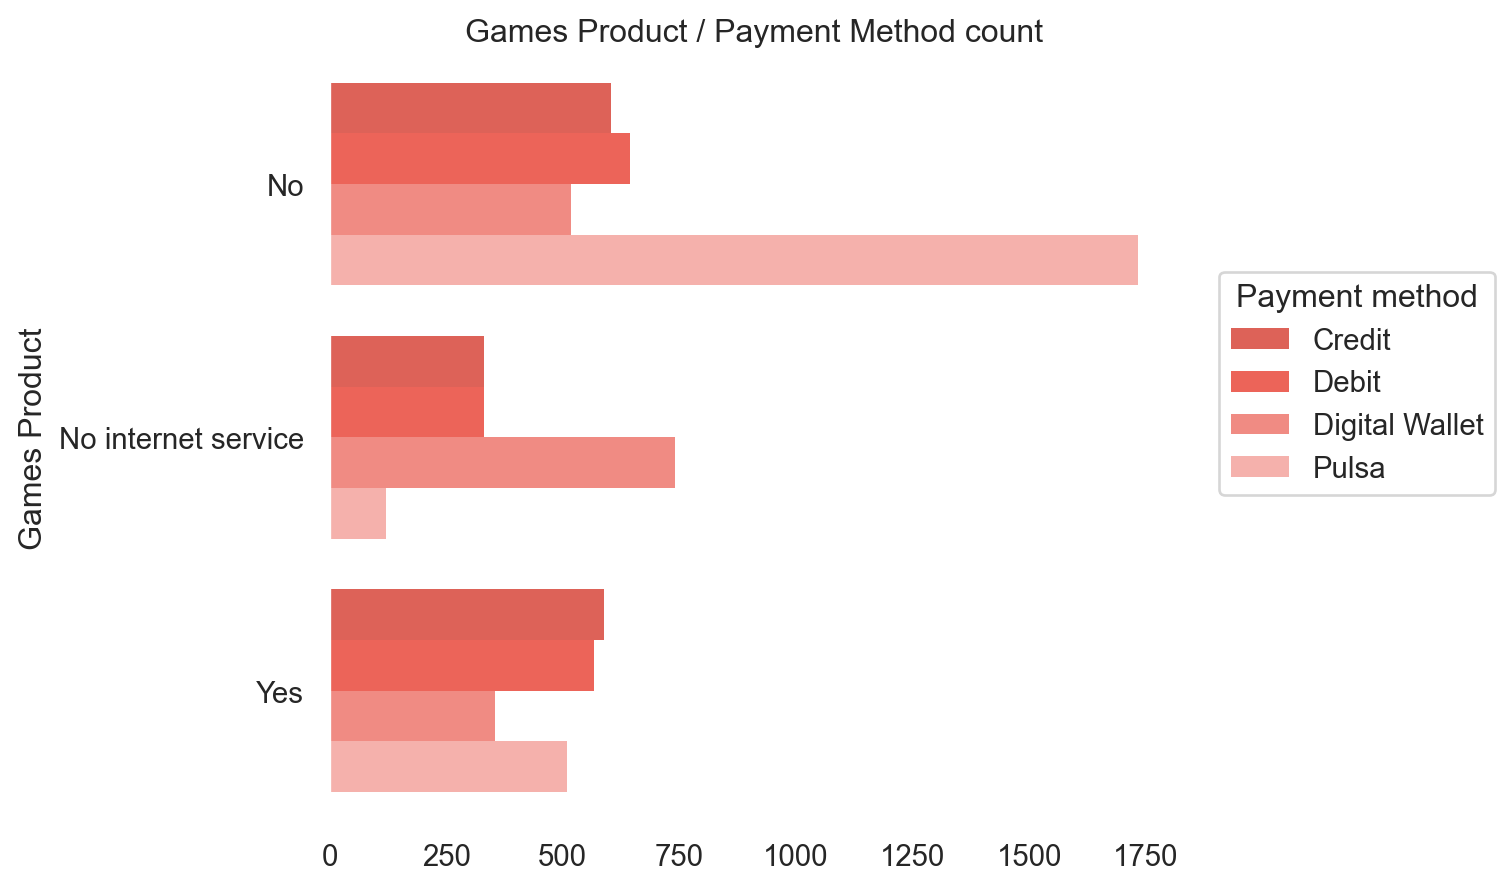

In [97]:
(so
 .Plot((df
 .groupby(['Games Product', 'Payment Method'])
 ['Payment Method']
 .describe()
 ["count"]
 .unstack(level=1)
 .reset_index()
 .melt(id_vars='Games Product', var_name='Payment Method', value_name='count')
 .astype({'count': 'int16'})
),
       x='count',
       y='Games Product',
       color='Payment Method')
 .add(so.Bar(edgewidth=0),
      so.Agg(),
      so.Dodge())
 .label(x='',
        y='Games Product',
        color=str.capitalize,
        title=f'Games Product / Payment Method count')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=color_palette), "axes.facecolor": "w", "grid.color": "#ffffff"})
)

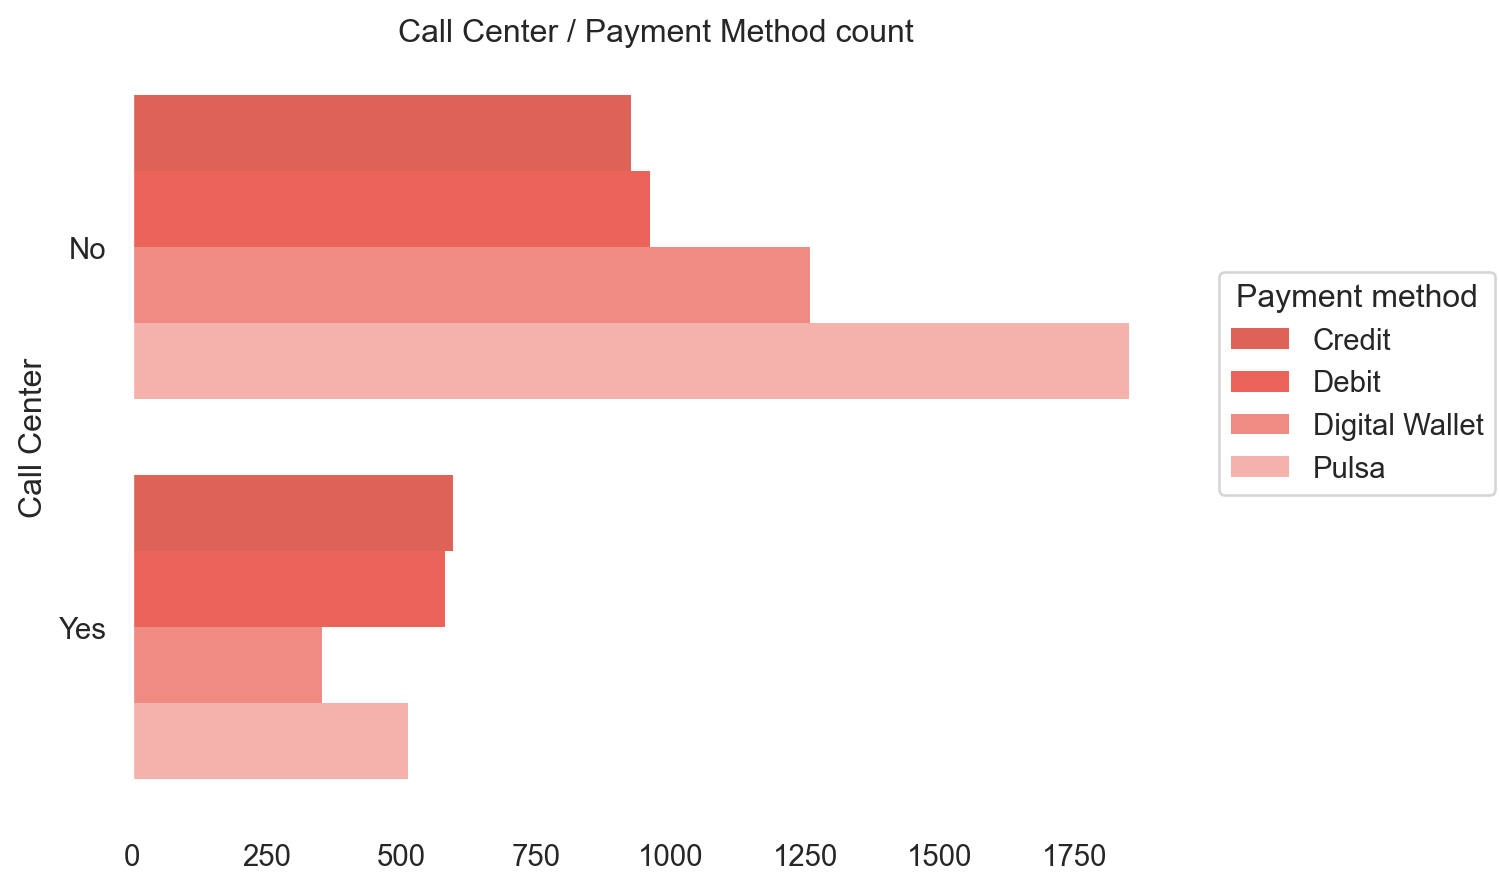

In [98]:
(so
 .Plot((df
 .groupby(['Call Center', 'Payment Method'])
 ['Payment Method']
 .describe()
 ["count"]
 .unstack(level=1)
 .reset_index()
 .melt(id_vars='Call Center', var_name='Payment Method', value_name='count')
 .astype({'count': 'int16'})
),
       x='count',
       y='Call Center',
       color='Payment Method')
 .add(so.Bar(edgewidth=0),
      so.Agg(),
      so.Dodge())
 .label(x='',
        y='Call Center',
        color=str.capitalize,
        title=f'Call Center / Payment Method count')
 .theme({"axes.prop_cycle": matplotlib.cycler(color=color_palette), "axes.facecolor": "w", "grid.color": "#ffffff"})
)

In [99]:
df_cat = pd.concat([df.select_dtypes('object'), df['churn_label']], axis=1)

label = LabelEncoder()
df_encoded = pd.DataFrame()

for i in df_cat.columns:
    if i != "churn_label":
        df_encoded[i] = label.fit_transform(df_cat[i])
    else:
        df_encoded[i] = label.fit_transform(df_cat[i].values.ravel())
    
def Cramers_V(var1, var2):
    crosstab = np.array(pd.crosstab(index=var1, columns=var2)) # Cross Tab
    return (association(crosstab, method='cramer'))            # Return Cramer's V

# Create the dataFrame matrix with the returned Cramer's V
rows = []

for var1 in df_encoded:
    col = []

    for var2 in df_encoded:
        V = Cramers_V(df_encoded[var1], df_encoded[var2]) # Return Cramer's V
        col.append(V)                                             # Store values to subsequent columns  
        
    rows.append(col)                                              # Store values to subsequent rows
    
CramersV_results = np.array(rows)
CramersV_df = (pd
               .DataFrame(CramersV_results, columns = df_encoded.columns, index = df_encoded.columns)
               .style
               .background_gradient(cmap=cm, axis=None)
               .set_sticky(axis="index")
               .set_sticky(axis="columns"))
CramersV_df

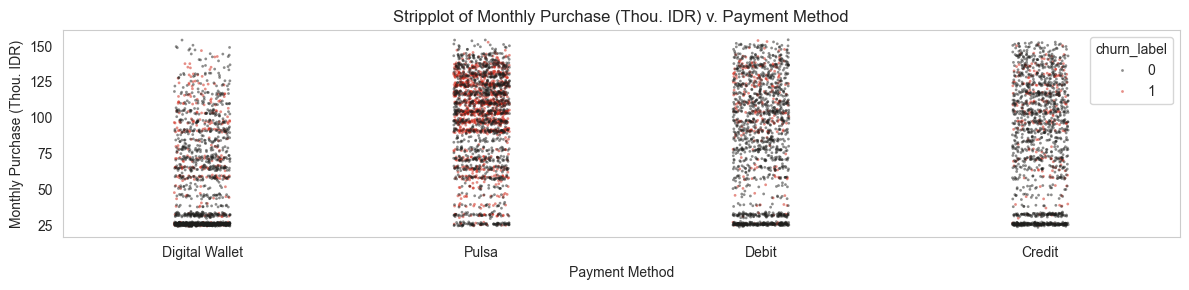

In [100]:
fig, axes = plt.subplots(figsize=(12, 3))
sns.stripplot(data=df, 
              x='Payment Method', 
              y=df["Monthly Purchase (Thou. IDR)"], 
              size=2, 
              hue="churn_label", 
              palette=[color_palette[7], color_palette[0]], 
              alpha=0.5,
              ax=axes,)
plt.title('Stripplot of Monthly Purchase (Thou. IDR) v. Payment Method')
plt.tight_layout();

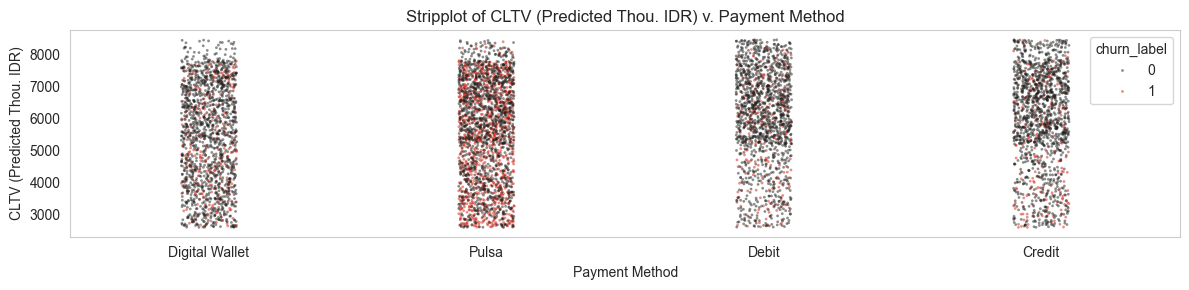

In [101]:
fig, axes = plt.subplots(figsize=(12, 3))
sns.stripplot(data=df, 
              x='Payment Method', 
              y=df["CLTV (Predicted Thou. IDR)"], 
              size=2, 
              hue="churn_label", 
              palette=[color_palette[7], color_palette[0]], 
              alpha=0.5,
              ax=axes,)
plt.title('Stripplot of CLTV (Predicted Thou. IDR) v. Payment Method')
plt.tight_layout();

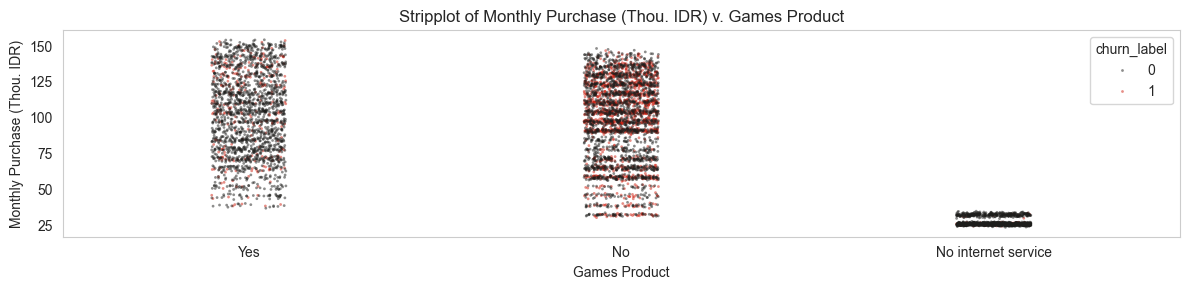

In [102]:
fig, axes = plt.subplots(figsize=(12, 3))
sns.stripplot(data=df, 
              x='Games Product', 
              y=df["Monthly Purchase (Thou. IDR)"], 
              size=2, 
              hue="churn_label", 
              palette=[color_palette[7], color_palette[0]], 
              alpha=0.5,
              ax=axes,)
plt.title('Stripplot of Monthly Purchase (Thou. IDR) v. Games Product')
plt.tight_layout();

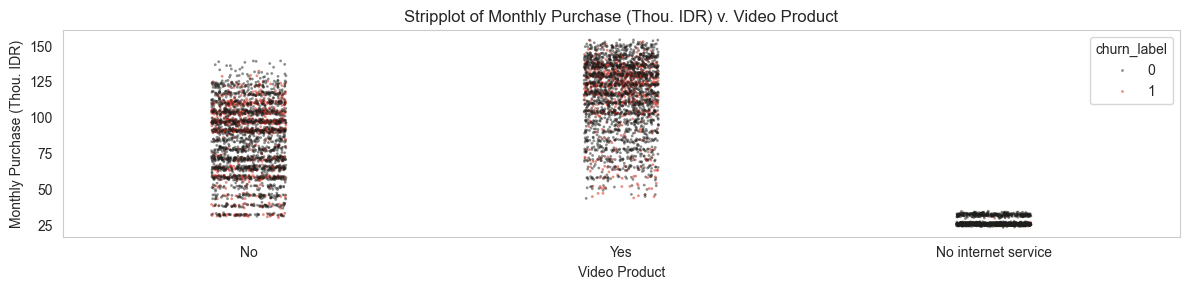

In [103]:
fig, axes = plt.subplots(figsize=(12, 3))
sns.stripplot(data=df, 
              x='Video Product', 
              y=df["Monthly Purchase (Thou. IDR)"], 
              size=2, 
              hue="churn_label", 
              palette=[color_palette[7], color_palette[0]], 
              alpha=0.5,
              ax=axes,)
plt.title('Stripplot of Monthly Purchase (Thou. IDR) v. Video Product')
plt.tight_layout();

In [104]:
df

Customer ID  Tenure Months Location Device Class        Games Product  \
0               0              2  Jakarta      Mid End                  Yes   
1               1              2  Jakarta     High End                   No   
2               2              8  Jakarta     High End                   No   
3               3             28  Jakarta     High End                   No   
4               4             49  Jakarta     High End                   No   
...           ...            ...      ...          ...                  ...   
7038         7038             72  Jakarta      Low End  No internet service   
7039         7039             24  Jakarta      Mid End                  Yes   
7040         7040             72  Jakarta     High End                   No   
7041         7041             11  Jakarta      Mid End                  Yes   
7042         7042             66  Jakarta     High End                  Yes   

            Music Product    Education Product Call Center  \
0                     Yes                   No          No   
1                      No                   No          No   
2                      No                  Yes          No   
3                      No                  Yes         Yes   
4                     Yes                  Yes          No   
...                   ...                  ...         ...   
7038  No internet service  No internet service          No   
7039                   No                  Yes         Yes   
7040                  Yes                  Yes          No   
7041                   No                   No          No   
7042                   No                  Yes         Yes   

            Video Product            Use MyApp  Payment Method  \
0                      No                   No  Digital Wallet   
1                      No                   No           Pulsa   
2                     Yes                  Yes           Pulsa   
3                     Yes                  Yes           Pulsa   
4                     Yes                  Yes           Debit   
...                   ...                  ...             ...   
7038  No internet service  No internet service           Debit   
7039                  Yes                  Yes  Digital Wallet   
7040                  Yes                  Yes          Credit   
7041                   No                   No           Pulsa   
7042                  Yes                  Yes           Debit   

      Monthly Purchase (Thou. IDR)  churn_label   Longitude  Latitude  \
0                           70.005            1  106.816666      -6.2   
1                           91.910            1  106.816666      -6.2   
2                          129.545            1  106.816666      -6.2   
3                          136.240            1  106.816666      -6.2   
4                          134.810            1  106.816666      -6.2   
...                            ...          ...         ...       ...   
7038                        27.495            0  106.816666      -6.2   
7039                       110.240            0  106.816666      -6.2   
7040                       134.160            0  106.816666      -6.2   
7041                        38.480            0  106.816666      -6.2   
7042                       137.345            0  106.816666      -6.2   

      CLTV (Predicted Thou. IDR)  
0                         4210.7  
1                         3511.3  
2                         6983.6  
3                         6503.9  
4                         6942.0  
...                          ...  
7038                      6897.8  
7039                      2782.0  
7040                      7228.0  
7041                      3630.9  
7042                      6626.1  

[7043 rows x 16 columns]

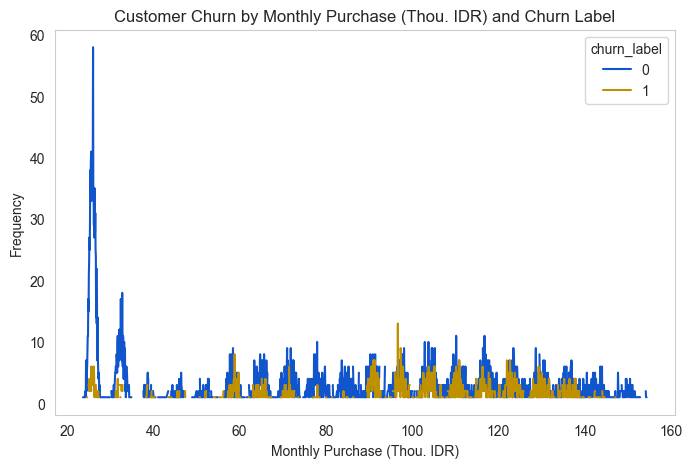

In [105]:
fig, ax = plt.subplots(figsize=(8,5))

(df
 .groupby('churn_label')
 ["Monthly Purchase (Thou. IDR)"]
 .value_counts()
 .unstack(level=0)
 .plot
 .line(title="Customer Churn by Monthly Purchase (Thou. IDR) and Churn Label", ylabel="Frequency", color=["#1155ccff", "#bf9000ff"], ax=ax)
);